# Effects of Dropouts on in Text and Image Classification


---


The main goal of the project is to study the effects of dropouts on the two specific fields of Deep
Learning i.e Image Classification and Text Classification

The two main areas of a Neural Network namely “Effects on Model Parameters”, and “Effects on
Feature Learning”. Model Parameters include the parameters based on which the performance of the
model is judged here we have included six model features in our study namely Accuracy, Loss,
Precision, Recall, ROC-AUC, and Learning Curve.

In order to study the effects on feature learning,
we use the concept of LIME(Locally Interpretable Model Agnostic Explanations).

Various
experimental setups were created in order to study the above-mentioned effects but in the big picture
following were the steps taken to conduct the studies:
1. Create the model pertaining to the dataset and whose features on which effects are to be
studied i.e Feed-Forward or Convolutional Neural Networks
2. Models created range from the dropout rates 0.0 to 0.9
3. Models are trained on the needed dataset and its effects on the Learning curve are recorded
4. During Test-Time analysis other model parameters are recorded to study effects on them
5. LIME is used if needed to study the features most effective in the predictions made and draw
relations between interpretability and dropout rates.

## Loading Datasets from Google Drive

In [ ]:
#Mounting google drive on colab
from google.colab import drive
drive.mount('/gdrive', force_remount = True) 

Mounted at /gdrive


In [ ]:
import pickle
import numpy as np

#Importing all the pickled dataset (in previous notebook) from google drive
arr = {}
for i in ['X_train_mnist', 'X_test_mnist', 'y_train_mnist', 'y_test_mnist', 'X_train_cifar', 'X_test_cifar', 'y_train_cifar', 'y_test_cifar']:
  file_name = i + '.pkl'
  arr[i] = (pickle.load(open(r"/gdrive/My Drive/" + file_name,'rb')))

In [ ]:
#Storing the imported dataset in their respective variables.

X_train_mnist = arr['X_train_mnist']
X_test_mnist = arr['X_test_mnist']
y_train_mnist = arr['y_train_mnist']
y_test_mnist = arr['y_test_mnist']
X_train_cifar = arr['X_train_cifar']
X_test_cifar = arr['X_test_cifar']
y_train_cifar = arr['y_train_cifar']
y_test_cifar = arr['y_test_cifar']

## CREATING MODELS

#Image Classification

### Import necessary libraries

In [ ]:
import tensorflow as tf
import keras
import pickle
import numpy as np
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Conv2D, AvgPool2D, Flatten, Dense
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.constraints import max_norm
from keras.utils import to_categorical
import os
import matplotlib.pyplot as plt
import imageio
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

### LeNet Architecture

There are 7 layers in LeNet


*   2 sets of Convolution layers
*   2 sets of Average Pooling Layers  
*   1 layer of flattening
*   2 fully connected layers 



In [ ]:
class lenet:
  '''
  There are 7 layers in LeNet:
  
  * 2 sets of Convolution layers
  * 2 sets of Average Pooling Layers
  * 1 layer of flattening
  * 2 fully connected layers
  
  model: sequential
  dropout1: True or False
  dropout_prob1: a probability ranging from 0 to 1
  dropout2: True or False
  dropout_prob2: a probability ranging from 0 to 1
  dropout3: True or False
  dropout_prob3: a probability ranging from 0 to 1
  maxnorm: True or False
  maxnorm_num: an integer number 
  momentum: True or False
  decay_lr: True or False
  
  '''

  def __init__(self, data = "", lr = 0.5, momentum = 0.0, dropout1 = False, dropout_prob1 = 0.0, dropout2 = False, dropout_prob2 = 0.0, maxnorm = False, maxnorm_num = 0, decay_lr = False):
    #Function to initialize necessray variables with the default values passed to the constructor
    self.model = Sequential()
    self.momentum = momentum
    self.lr = lr
    self.optim = tf.keras.optimizers.SGD(
    learning_rate = self.lr, momentum=self.momentum, name='SGD')

    self.dropout1 = dropout1
    self.dropout_prob1 = dropout_prob1
    self.dropout2 = dropout2
    self.dropout_prob2 = dropout_prob2
    self.maxnorm = maxnorm
    self.maxnorm_num = maxnorm_num
    self.decay_lr = decay_lr
    self.history = {}
    self.dataset = data 

  def create_network(self):
    #Function to create a network of LENET-5 architecture for MNIST dataset
    if self.dataset == "MNIST":
      # Adding a Convolution Layer C1
      # Size of each feature map in C1 is (N-f+2P)/S +1 = 28-5+1 = 24
      # No. of parameters between input layer and C1 = (5*5 + 1)*6 = 156
      self.model.add(Conv2D(filters=6, kernel_size=(5,5), padding='valid', input_shape=(28,28,1), activation='tanh'))

      # Adding an Average Pooling Layer S2
      # No. of parameters between C1 and S2 = (1+1)*6 = 12
      self.model.add(AvgPool2D(pool_size=(2,2)))

      # Adding a Convolution Layer C3
      # No. of parameters between S2 and C3 = (5*5*6*16 + 16) + 16 = 2416
      self.model.add(Conv2D(filters=16, kernel_size=(5,5), padding='valid', activation='tanh'))

      # Adding an Average Pooling Layer S4
      # Size of each feature map in S4 is (N-f+2P)/S +1 = (8-2+0)/2+1 = 3+1 = 4
      # No. of parameters between C3 and S4 = (1+1)*16 = 32
      self.model.add(AvgPool2D(pool_size=(2,2)))

    elif self.dataset == "CIFAR":
      #Function to create a convolutional neural network with the following architecture.
      # 1. 4 2-DConvolutional layers
      # 2. Each followed by an Average Pooling layer
      # 3. A Flatten layer 
      # 4. Followed by 3 fully connected layers of the sizes [256, 128]
      # 5. And an output layer of size 10
      self.model.add(Conv2D(filters = 32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3), padding = "same"))
      
      self.model.add(AvgPool2D(pool_size = (2, 2)))
      
      self.model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding="same"))
      
      self.model.add(AvgPool2D(pool_size = (2, 2)))

      self.model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding = "same"))

      self.model.add(AvgPool2D(pool_size = (2, 2)))

      self.model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding = "same"))
      
      self.model.add(AvgPool2D(pool_size = (2, 2)))

    # Flattening the layer S4
    self.model.add(Flatten())

    #Adding first fully connected layer
    lenet.fcc_layer(self, 256, self.maxnorm, self.maxnorm_num)

    #Adding a dropout layer if "dropout == True"
    lenet.dropout_layer(self, self.dropout1, self.dropout_prob1)

    #Adding second fully connected layer
    lenet.fcc_layer(self, 128, self.maxnorm, self.maxnorm_num)

    #Adding a dropout layer if "dropout == True"
    lenet.dropout_layer(self, self.dropout2, self.dropout_prob2)

    # Adding a Dense layer with `softmax` activation
    # No. of inputs = 84
    # No. of outputs = 10
    # No. of parameters = 84*10 + 10 = 850
    self.model.add(Dense(10, activation='softmax'))

  def dropout_layer(self, dropout, probability):
    #Adding a dropout layer with input probability
    if dropout == True:
      self.model.add(Dropout(probability))
    else:
      pass

  def fcc_layer(self, neurons, maxnorm, maxnorm_num): 
    # Adding a Dense layer with `tanh` activation
    # No. of parameters = input*neurons + neurons(bias units)
    if maxnorm == True:
      self.model.add(Dense(neurons, activation='tanh', bias_constraint=max_norm(maxnorm_num)))
    else:  
      self.model.add(Dense(neurons, activation='tanh'))
  
  def features(self):
    try:
      self.model.summary()
    except:
      print("Model has not yet been built try calling try calling 'build()' function")

  def compile_model(self):
    #Compile the model created for the following parameters
    # 1. Accuracy, 2. Precision, 3. Recall, ROC-AUC
    self.model.compile(optimizer=self.optim, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

  def fit_model(self, X_train, y_train, callback, num_epoch, b_size, split):
    #Function to fit the model according to the dataset used
    if self.dataset == "CIFAR":
      epoch = 20
      split = 0.15
    else:
      epoch = num_epoch

    lenet.history = self.model.fit(X_train, y_train, callbacks = callback, epochs = epoch, batch_size = b_size, validation_split=split, verbose=2)
    
    return lenet.history
    
  def test_model(self, X_test, y_test):
    #Evaluate the model on the test set using the evaluate() function
    lenet.history = self.model.evaluate(X_test, y_test)
    return lenet.history

In [ ]:
print(lenet.__doc__)


  There are 7 layers in LeNet:
  
  * 2 sets of Convolution layers
  * 2 sets of Average Pooling Layers
  * 1 layer of flattening
  * 2 fully connected layers
  
  model: sequential
  dropout1: True or False
  dropout_prob1: a probability ranging from 0 to 1
  dropout2: True or False
  dropout_prob2: a probability ranging from 0 to 1
  dropout3: True or False
  dropout_prob3: a probability ranging from 0 to 1
  maxnorm: True or False
  maxnorm_num: an integer number 
  momentum: True or False
  decay_lr: True or False
  
  


### Feed Forward Neural Network

In [ ]:
class ann:
  '''
  model: sequential
  dropout_prob: list of dropout probability
  maxnorm_num: list of maxnorm parameter
  momentum: True or False
  decay_lr: True or False

  '''
  def __init__(self, lr, momentum, hidden_layer_size = [], dropout_prob = [], maxnorm_num = [], decay_lr = False):
    self.model = Sequential()
    self.lr = lr
    self.momentum = momentum
    
    self.optim = tf.keras.optimizers.SGD(
    learning_rate = self.lr, momentum=self.momentum, name='SGD')
    
    self.layer_size = hidden_layer_size
    self.dropout_prob = dropout_prob
    self.maxnorm_num = maxnorm_num
    self.decay_lr = decay_lr

  def create_network(self):
    self.model.add(Flatten())
    #Loop iterates over layer sizes to add dense layers to model
    for i in self.layer_size:
      try: #Checks if maxnorm parameter is given or not and adds a layer accordingly
        num = self.maxnorm_num.pop(0)
        self.model.add(Dense(i, activation='relu', bias_constraint=max_norm(num)))
      except: #else creates a dense layer without maxnorm constraint 
        self.model.add(Dense(i, activation='relu'))
      try:# Similarly checks for dropout_prob
        prob = self.dropout_prob.pop(0)
        self.model.add(Dropout(prob))
      except:
        pass
    # Add a final output layer with softmax activation
    self.model.add(Dense(10, activation = 'sigmoid'))
    
  def features(self): #Provides a model summary
    try:
      self.model.summary()
    except:
      print("Model has not yet been built try calling try calling 'build()' function")

  def compile_model(self):
  #Compile the model created for the following parameters
  # 1. Accuracy, 2. Precision, 3. Recall, ROC-AUC
    self.model.compile(optimizer=self.optim, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

  def fit_model(self, X_train, y_train, epoch, batchSize, split):
  #Function to fit the model according to the dataset used
    ann.history = self.model.fit(X_train, y_train, epochs = epoch, batch_size = batchSize, validation_split= split, verbose=2)
    return ann.history
    
  def test_model(self, X_test, y_test):
  #Evaluate the model on the test set using the evaluate() function
    ann.history = self.model.evaluate(X_test, y_test)
    return ann.history

## GRAPH PLOTTING FUNCTIONS

In [ ]:
def plot_learning_curve_acc(history, plt):
  #Function plots training and validation accuracy for each training epoch

  plt.style.use(['ggplot'])
  plt.plot(history.history['val_accuracy'], 'o-')
  plt.plot(history.history['accuracy'], 'x-')
  plt.legend(['validation', 'training'], loc = 'lower right')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  return plt

In [ ]:
def plot_learning_curve_loss(history, plt):

  #Function to plot a line graph for average ROC-AUC for each dropout rates
  plt.style.use(['ggplot'])
  plt.plot(history.history['val_loss'], 'o-')
  plt.plot(history.history['loss'], 'x-')
  plt.legend(['validation', 'train'], loc = 'upper right')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  return plt

In [ ]:
def plot_gif(arr, choice):

  '''if:
    choice: 1 => learning curve for loss
    choice: 2 => learning curve for accuracy'''

  import matplotlib.pyplot as plt

  filenames = []

  for i in dropout_lis:
    if choice == 'loss':
      filename = f'{i}_loss.png'
      plt = plot_learning_curve_loss(arr[i], plt)
    elif choice == 'acc':
      filename = f'{i}_acc.png'
      plt = plot_learning_curve_acc(arr[i], plt)

    
    plt.xlabel("epoch (Dropout probability: "+str(i)+")")
    plt.savefig(os.path.join("/gdrive/My Drive/", filename))  
    filenames.append(imageio.imread(os.path.join("/gdrive/My Drive/", filename)))
    plt.show()
    plt.close()

#    plt2.savefig(os.path.join("/gdrive/My Drive/", filename2))  
#    filenames2.append(imageio.imread(os.path.join("/gdrive/My Drive/", filename2)))
#    plt2.close()


  if choice == 'loss':
    imageio.mimsave(os.path.join("/gdrive/My Drive/loss_plot.gif"), filenames, duration = 1.5, fps = 60)
  elif choice == 'acc':
    imageio.mimsave(os.path.join("/gdrive/My Drive/acc_plot.gif"), filenames, duration = 1.5, fps = 60)

In [ ]:
def acc_graph(test_history):
  #input data points for x-axis
  x = np.array(dropout_lis)

  y1 = []
  y2 = []
  y3 = []

  max_acc = 0

  #data points for y-axis
  for i in dropout_lis:
    y1.append(test_history[i][0])
    y2.append(test_history[i][1])

  
    if test_history[i][1] > max_acc:
      max_acc = test_history[i][1]

  ax = plt.subplot(1, 1, 1)

  #Ploting bar charts with a displacement of 0.2 to avoid overlapping of bars
  plt.ylim(0.8, 0.9)
  ax.bar(x, y2, color='#800080', width = 0.03, align='center')
  plt.axhline(max_acc, color = '#B22222')

  #ggplot pre-defined style used to beautify
  plt.style.use('ggplot')

  #Labels for x and y-axis
  plt.xlabel("dropout prob.")
  plt.ylabel("Accuracy")

  #Title for the bar chart
  plt.title("Dropout v. Accuracy")

  plt.show()

In [ ]:
def loss_graph(test_history):
  x = dropout_lis

  min_loss = float('inf')
  y1 = []
  #data points for y-axis
  for i in dropout_lis:
    y1.append(test_history[i][0])
    if test_history[i][1] < min_loss:
      min_loss = test_history[i][0]

  #Using pre-defined style to beautify graph
  plt.style.use('ggplot')

  #Assign title to graph
  plt.title("Trends in Loss function with dropout rates")

  #Assign x and y label to axes
  plt.xlabel("Dropout rate")
  plt.ylabel("Loss")

  plt.plot(x, y1, 'o-', linewidth = '1.5', color = "#BA0F30")
  #plt.hlines(y = min_loss, xmin=0, xmax=1, colors='aqua', linestyles='-', lw=0.5, label='Single Short Line')


  plt.show()

In [ ]:
def roc_graph(test_history):
  #input data points for x-axis
  x = np.array(dropout_lis)

  y1 = []

  max_roc = 0

  #data points for y-axis
  for i in dropout_lis:
    y1.append(test_history[i][2])
  
    if test_history[i][2] > max_roc:
      max_roc = test_history[i][2]

  ax = plt.subplot(1, 1, 1)

  #Ploting bar charts with a displacement of 0.2 to avoid overlapping of bars
  plt.ylim(0.9, 0.95)
  ax.bar(x, y1, color='#800080', width = 0.03, align='center')
  plt.axhline(max_roc, color = '#B22222')

  #ggplot pre-defined style used to beautify
  plt.style.use('ggplot')

  #Labels for x and y-axis
  plt.xlabel("dropout prob.")
  plt.ylabel("ROC-AUC")

  #Title for the bar chart
  plt.title("Dropout v. ROC-AUC")

  plt.show()

In [ ]:
def prec_graph(test_history):
  x = dropout_lis

  min_loss = float('inf')
  y1 = []
  #data points for y-axis
  for i in dropout_lis:
    y1.append(test_history[i][4])

  #Using pre-defined style to beautify graph
  plt.style.use('ggplot')

  #Assign title to graph
  plt.title("Trends in Precision with dropout rates")

  #Assign x and y label to axes
  plt.xlabel("Dropout rate")
  plt.ylabel("Precision")

  plt.plot(x, y1, 'o-', linewidth = '1.5', color = "#189AB4")


  plt.show()

In [ ]:
def recall_graph(test_history):
  x = dropout_lis

  min_loss = float('inf')
  y1 = []
  #data points for y-axis
  for i in dropout_lis:
    y1.append(test_history[i][3])

  #Using pre-defined style to beautify graph
  plt.style.use('ggplot')

  #Assign title to graph
  plt.title("Trends in Recall with dropout rates")

  #Assign x and y label to axes
  plt.xlabel("Dropout rate")
  plt.ylabel("Recall")

  plt.plot(x, y1, 'o-', linewidth = '1.5', color = "#BA0F30")
  #plt.hlines(y = min_loss, xmin=0, xmax=1, colors='aqua', linestyles='-', lw=0.5, label='Single Short Line')


  plt.show()

## EFFECTS ON MODEL PARAMETERS


### CIFAR-10

In [ ]:
#Convert data type of dataset to float.
X_train_cifar = X_train_cifar.astype('float32')
X_test_cifar = X_test_cifar.astype('float32')

#Normalize the pixle data in both train and test set to bring mean andstandard deviation between 0 and 1
X_train_cifar = X_train_cifar / 255.0
X_test_cifar = X_test_cifar / 255.0

In [ ]:
np.std(X_train_cifar)

0.2515689

In [ ]:
np.mean(X_train_cifar)

0.4733623

In [ ]:
#Convert the output labels to categorical data.
y_train_cifar = to_categorical(y_train_cifar)
y_test_cifar = to_categorical(y_test_cifar)

In [ ]:
#Iterate over dropout rates and create a network for CIFAR-10 dataset
dropout_lis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
cnn_cifar_models = {}
for i in dropout_lis:
  if i != 0: 
    cnn_cifar_models[i] = lenet("CIFAR", 0.1, 0.0, True, i, True, i, False, 0, False)
  else:
    cnn_cifar_models[i] = lenet("CIFAR", 0.1, 0.0, False, 0, False, 0, False, 0, False)
  cnn_cifar_models[i].create_network()

In [ ]:
#Model dropout without dropout
cnn_cifar_models[0.0].features()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
average_pooling2d_40 (Averag (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
average_pooling2d_41 (Averag (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
average_pooling2d_42 (Averag (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 4, 4, 128)       

In [ ]:
#Model dropout without dropout
cnn_cifar_models[0.1].features()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
average_pooling2d_44 (Averag (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
average_pooling2d_45 (Averag (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
average_pooling2d_46 (Averag (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 4, 4, 128)       

In [ ]:
cnn_cifar_model_history = {}

#Train the models on the dataset for each individual dropout rate.
for i in dropout_lis:
  print("################# Training model for dropout rate",i , "#################")
  cnn_cifar_models[i].compile_model()
  history = cnn_cifar_models[i].fit_model(X_train_cifar, y_train_cifar)
  cnn_cifar_model_history[i] = history
  print()

################# Training model for dropout rate 0.0 #################
Epoch 1/20
425/425 - 37s - loss: 2.1021 - accuracy: 0.2236 - auc: 0.6901 - recall: 0.0086 - precision: 0.4874 - val_loss: 1.9333 - val_accuracy: 0.2875 - val_auc: 0.7611 - val_recall: 0.0112 - val_precision: 0.6774
Epoch 2/20
425/425 - 3s - loss: 1.7860 - accuracy: 0.3555 - auc: 0.8048 - recall: 0.0826 - precision: 0.6121 - val_loss: 1.6167 - val_accuracy: 0.4121 - val_auc: 0.8467 - val_recall: 0.1451 - val_precision: 0.6377
Epoch 3/20
425/425 - 3s - loss: 1.5817 - accuracy: 0.4282 - auc: 0.8532 - recall: 0.1796 - precision: 0.6443 - val_loss: 1.5449 - val_accuracy: 0.4252 - val_auc: 0.8612 - val_recall: 0.1832 - val_precision: 0.6552
Epoch 4/20
425/425 - 3s - loss: 1.4724 - accuracy: 0.4692 - auc: 0.8745 - recall: 0.2423 - precision: 0.6732 - val_loss: 1.4257 - val_accuracy: 0.4897 - val_auc: 0.8833 - val_recall: 0.2523 - val_precision: 0.6798
Epoch 5/20
425/425 - 3s - loss: 1.3812 - accuracy: 0.5044 - auc: 0.8906

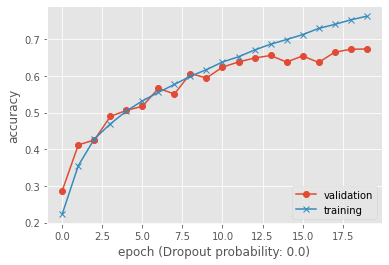

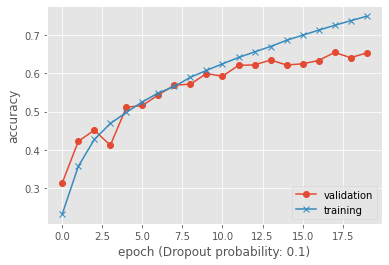

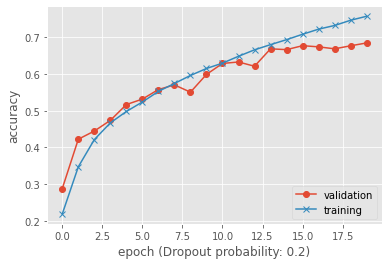

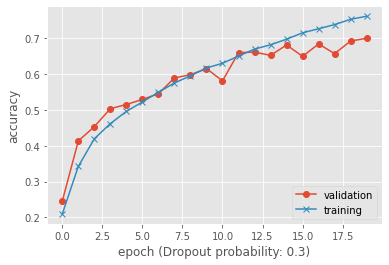

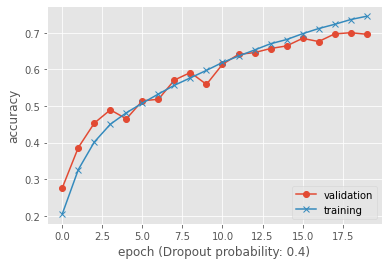

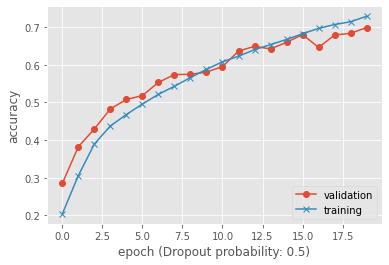

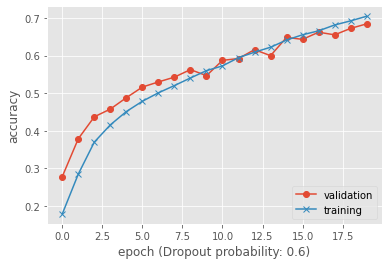

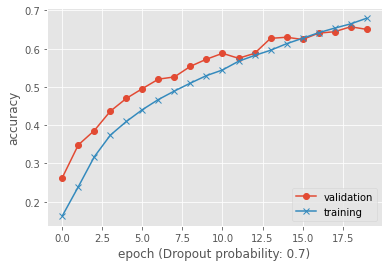

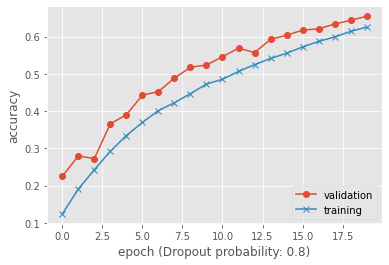

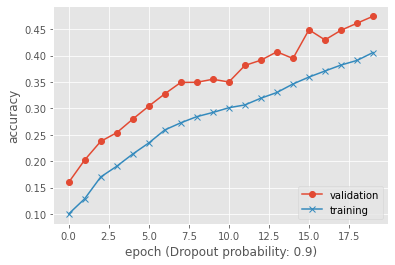

In [ ]:
#Plot learning for each model of different dropout rate and save GIF of all the plots created
plot_gif(cnn_cifar_model_history, 'acc')

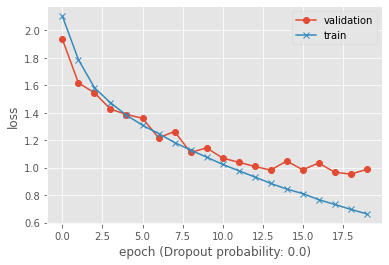

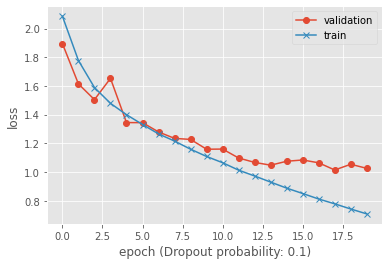

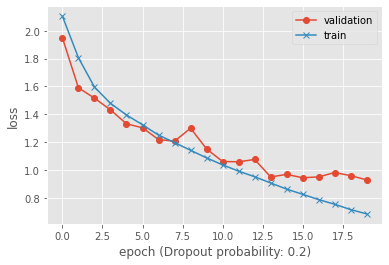

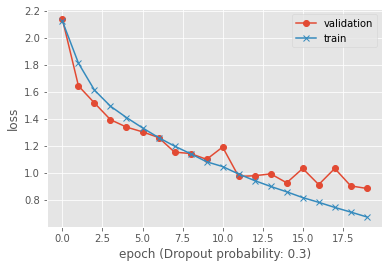

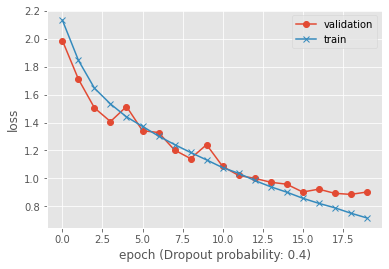

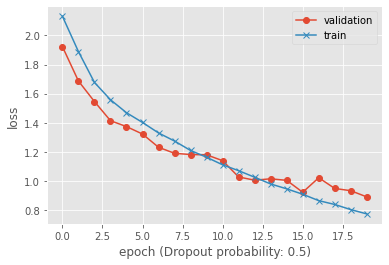

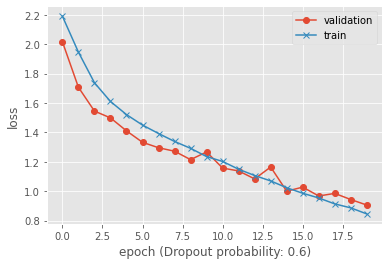

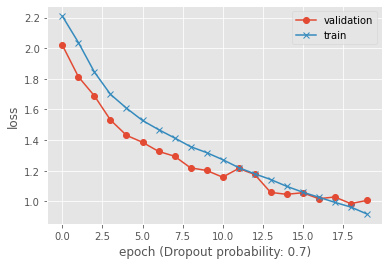

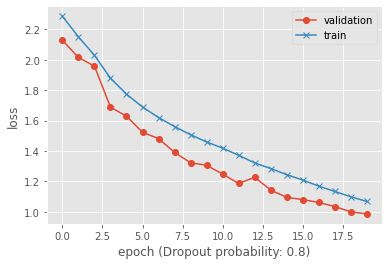

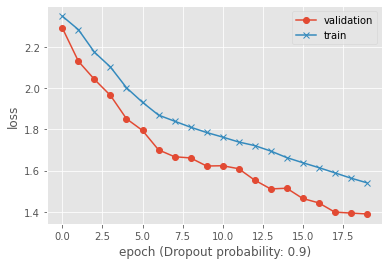

In [ ]:
#Plotting gif of learning curve for loss 
plot_gif(cnn_cifar_model_history, 'loss')

In [ ]:
#Evaluate the models on the test set for each dropout rate from 0.0 to 0.9.
cifar_cnn_test_history = {}
for i in dropout_lis:
  cifar_cnn_test_history[i] = cnn_cifar_models[i].test_model(X_test_cifar, y_test_cifar)

313/313 [==============================] - 3s 8ms/step - loss: 1.3994 - accuracy: 0.4739 - auc_50: 0.8930 - recall_39: 0.1707 - precision_39: 0.7196


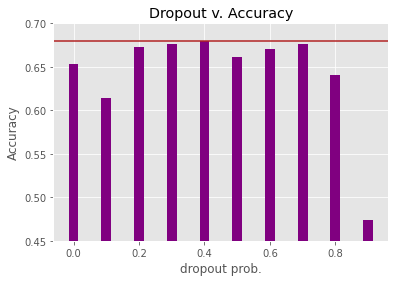

In [ ]:
#Plot bar graph of accuracy for each dropout rate
acc_graph(cifar_cnn_test_history)

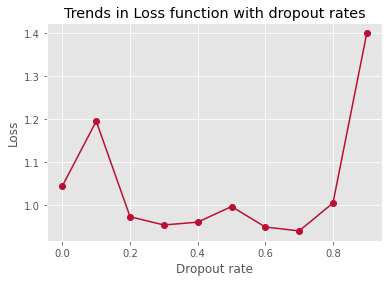

In [ ]:
#Plot line graph of loss for each dropout rate
loss_graph(cifar_cnn_test_history)

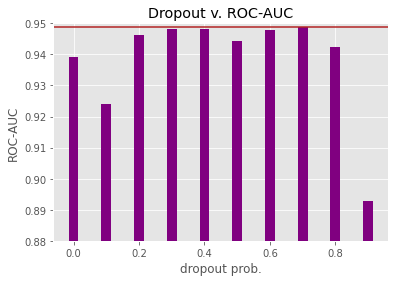

In [ ]:
#Plot bar graph of ROC-AUC for each dropout rate

roc_graph(cifar_cnn_test_history)

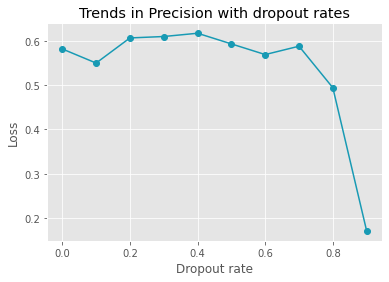

In [ ]:
#Plot line graph of precision for each dropout rate

prec_graph(cifar_cnn_test_history)

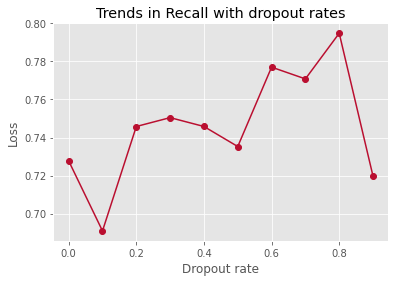

In [ ]:
#Plot line graph of recall for each dropout rate

recall_graph(cifar_cnn_test_history)

### MNIST

In [ ]:
#Reshape datasets to 3-D format.
X_train_mnist = X_train_mnist.reshape(60000, 28, 28, 1)
X_test_mnist = X_test_mnist.reshape(10000, 28, 28, 1)

Both train and test ing datasetsare normalized to make the *mean = 0* & *standard deviation between 0 and 1*

In [ ]:
#Normalize dataset to bring the mean and standard deviation b/w 0 and 1.
X_train_mnist = X_train_mnist.astype('float32')
X_test_mnist = X_test_mnist.astype('float32')
X_train_mnist = X_train_mnist / 255.0
X_test_mnist = X_test_mnist / 255.0

In [ ]:
np.std(X_train_mnist)

0.30810776

In [ ]:
np.mean(X_train_mnist)

0.13066062

Both training and testing labels are are changed into categorical variables with 10 classes and of shape: 



1.   For training labels (60000, 10)
2.   For testing labels (10000, 10)



In [ ]:
#Convert output labels to categorical variables where each row is of dimensions [1 * 10]
y_train_mnist = to_categorical(y_train_mnist)
y_test_mnist = to_categorical(y_test_mnist)

In [ ]:
#Iterate over dropout rates to create models for MNIST dataset from 0.0 to 0.9
dropout_lis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
cnn_mnist_models = {}
for i in dropout_lis:
  if i != 0: 
    cnn_mnist_models[i] = lenet("MNIST", 0.1, 0.0, True, i, True, i, False, 0, False)
  else:
    cnn_mnist_models[i] = lenet("MNIST", 0.1, 0.0, False, 0, False, 0, False, 0, False)
  cnn_mnist_models[i].create_network()

In [ ]:
#Model dropout without dropout
cnn_mnist_models[0.0].features()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 24, 24, 6)         156       
_________________________________________________________________
average_pooling2d_40 (Averag (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 8, 8, 16)          2416      
_________________________________________________________________
average_pooling2d_41 (Averag (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_31 (Dense)             (None, 128)             

In [ ]:
#Model structure with dropout
cnn_mnist_models[0.2].features()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 24, 24, 6)         156       
_________________________________________________________________
average_pooling2d_44 (Averag (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 8, 8, 16)          2416      
_________________________________________________________________
average_pooling2d_45 (Averag (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)             

In [ ]:
#Train models of each dropout rate on the training dataset for MNIST and store the history of acc., loss in a dictionary "cnn_mnist_history" 
cnn_mnist_history = {}
for i in dropout_lis:
  print("################# Training model for dropout rate",i , "#################")
  cnn_mnist_models[i].compile_model()
  history = cnn_mnist_models[i].fit_model(X_train_mnist, y_train_mnist)
  cnn_mnist_history[i] = history
  print()

################# Training model for dropout rate 0.0 #################
Epoch 1/5
360/360 - 36s - loss: 0.4457 - accuracy: 0.8744 - auc: 0.9882 - recall: 0.8096 - precision: 0.9359 - val_loss: 0.2293 - val_accuracy: 0.9330 - val_auc: 0.9957 - val_recall: 0.9190 - val_precision: 0.9498
Epoch 2/5
360/360 - 2s - loss: 0.1808 - accuracy: 0.9464 - auc: 0.9971 - recall: 0.9354 - precision: 0.9591 - val_loss: 0.1486 - val_accuracy: 0.9553 - val_auc: 0.9979 - val_recall: 0.9471 - val_precision: 0.9653
Epoch 3/5
360/360 - 2s - loss: 0.1188 - accuracy: 0.9646 - auc: 0.9985 - recall: 0.9576 - precision: 0.9721 - val_loss: 0.1086 - val_accuracy: 0.9672 - val_auc: 0.9985 - val_recall: 0.9613 - val_precision: 0.9730
Epoch 4/5
360/360 - 2s - loss: 0.0902 - accuracy: 0.9737 - auc: 0.9990 - recall: 0.9695 - precision: 0.9786 - val_loss: 0.0914 - val_accuracy: 0.9717 - val_auc: 0.9989 - val_recall: 0.9680 - val_precision: 0.9777
Epoch 5/5
360/360 - 2s - loss: 0.0733 - accuracy: 0.9784 - auc: 0.9993 - re

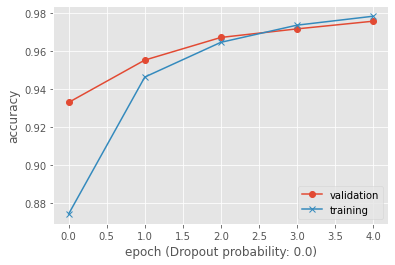

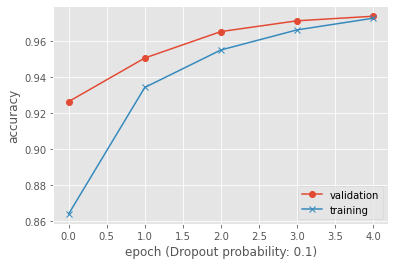

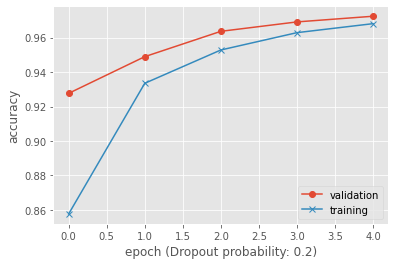

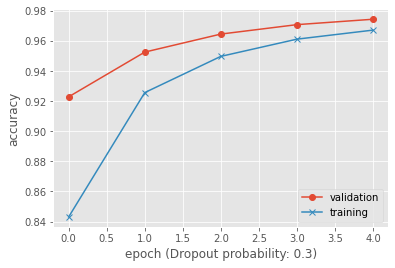

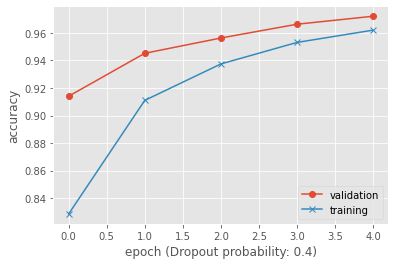

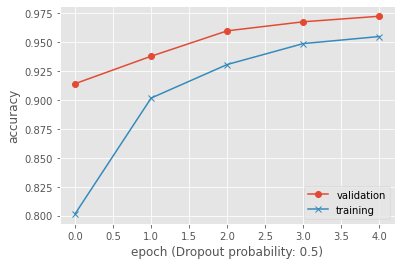

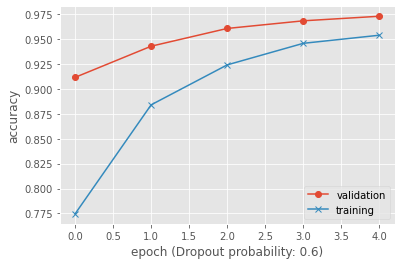

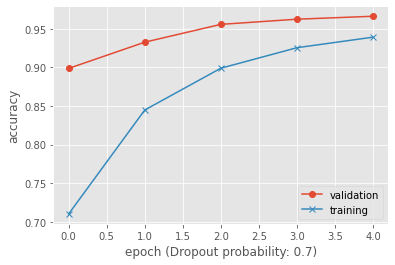

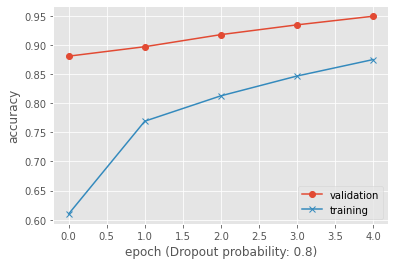

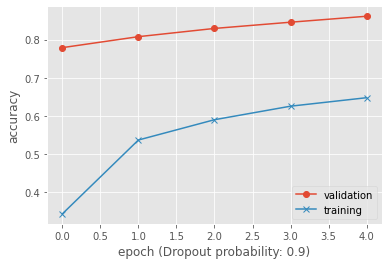

In [ ]:
#Plotting gif of learning curve for accuracy 
plot_gif(cnn_mnist_history, 'acc')

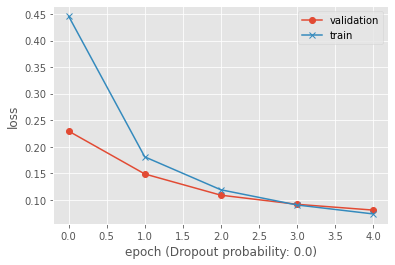

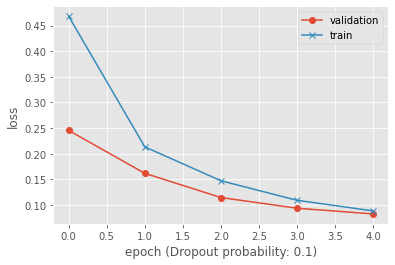

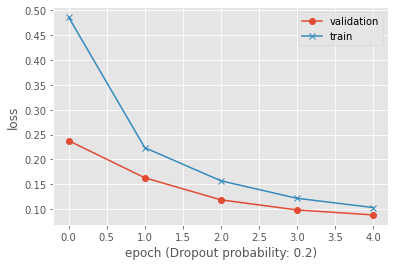

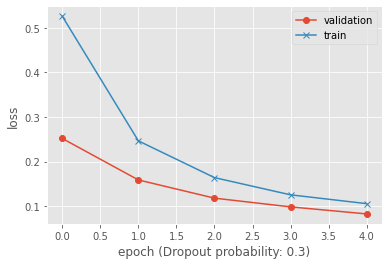

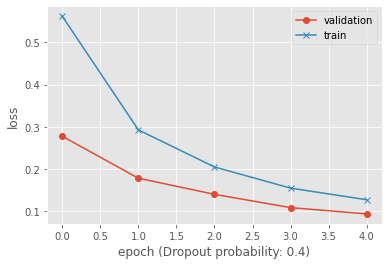

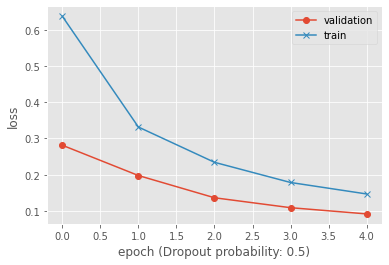

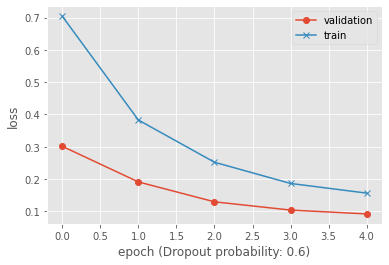

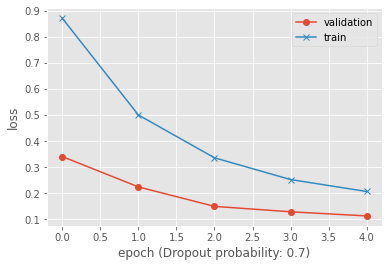

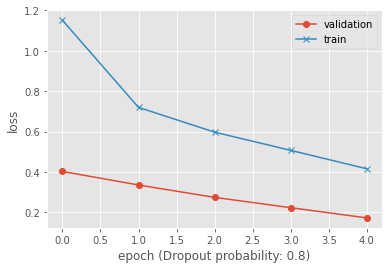

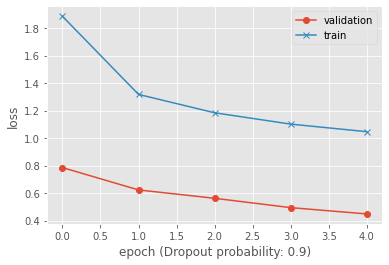

In [ ]:
#Plotting gif of learning curve for loss 
plot_gif(cnn_mnist_history, 'loss')

TEST TIME ANALYSIS FOR CONVOLUTIONAL NEURAL NETWORK

In [ ]:
#Evaluate the models on the test set for MNIST dataset for each dropout ate from 0.0 to 0.9
cnn_test_history = {}
for i in dropout_lis:
  cnn_test_history[i] = cnn_mnist_models[i].test_model(X_test_mnist, y_test_mnist)

313/313 [==============================] - 2s 5ms/step - loss: 0.4307 - accuracy: 0.8660 - auc_9: 0.9871 - recall_9: 0.8364 - precision_9: 0.8977


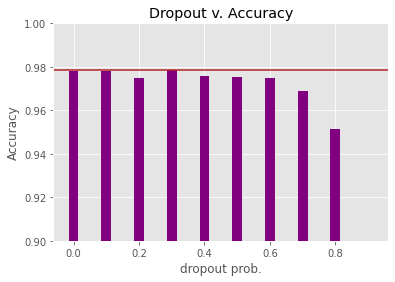

In [ ]:
#Plot bar graph to compare accuracies for different dropout rate  
acc_graph(cnn_test_history)

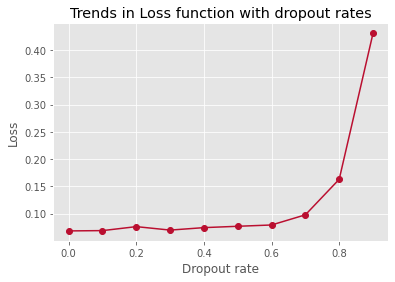

In [ ]:
#Plot line graph to compare loss on each dropout rate
loss_graph(cnn_test_history)

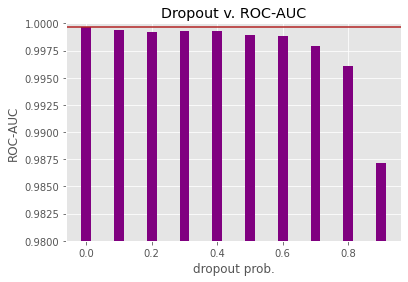

In [ ]:
#Plot bar graph to compare ROC-AUC for different dropout probability
roc_graph(cnn_test_history)

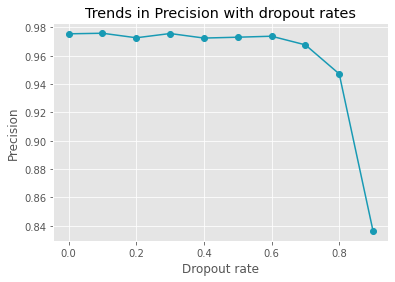

In [ ]:
#Plot line graph to compare precision for different dropout rates
prec_graph(cnn_test_history)

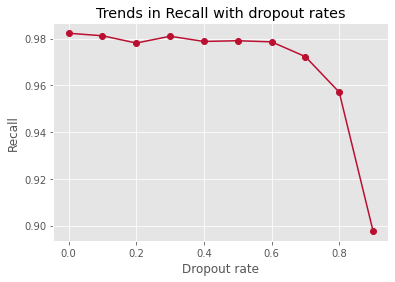

In [ ]:
#Plot line graph to compare recall for different dropout rates  
recall_graph(cnn_test_history)

INFERENCES:

* It can be well infered from the learning curve plots of both loass and accuracy: A dropout probability of ***p = 0.1***  gives the best results as  ***without any dropouts the model over-fits*** with a lower cross validation accuracy as compared to the training accuracy. And the gap b/w training and cross validation accuracy falls as the probability approaches 0.5 and then again starts increasing from the point further.


* Another result to note is that with the ***increasing dropout probability the training accuracy falls below cross validation accuracy*** that's because the number of neurons available at the time of training are less than at the cross validation time, which suggests that ***dropouts work in a similar way to ensemble methods*** where several weak learners are combined at the test time to provide a better model  



*   For loss function dropout probability = 0.2 has the optimal value of 0.0633.



*   Whereas, for accuracy dropout probability = 0.1, 0.2, and 0.3 give aolmost the same accuracy of ~ 0.97. 




*   For Accuracy, as the dropout rate increases the accuracy decreases similarly the value of loss function increases as the dropout is increasing.








In [ ]:
dropout_lis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ann_models = {}
for i in dropout_lis:
  ann_models[i] = ann(0.5, 0.0, [2048, 1024, 512, 256], [i, i, i, i], [], False)
  ann_models[i].create_network()
  ann_models[i].compile_model()

In [ ]:
model_history = {}
for i in dropout_lis:
  print("################# Training model for dropout rate",i , "#################")
  history = ann_models[i].fit_model(X_train_mnist, y_train_mnist, 5, 100, 0.2)
  model_history[i] = history
  print()

TEST TIME ANALYSIS FOR FEED FORWARD NEURAL NETWORK

In [ ]:
ann_test_history = {}
for i in dropout_lis:
  ann_test_history[i] = ann_models[i].test_model(X_test_mnist, y_test_mnist)

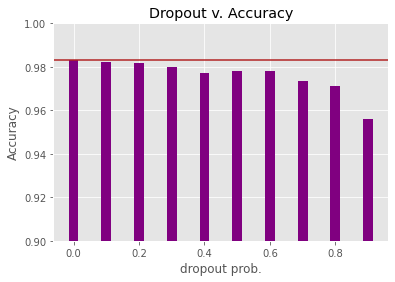

In [ ]:
acc_graph(ann_test_history)

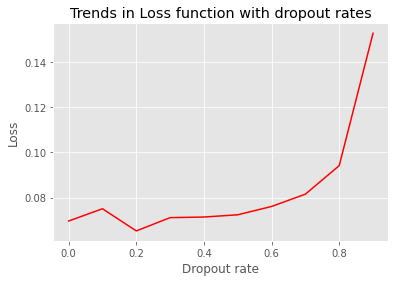

In [ ]:
loss_graph(ann_test_history)

### Effects of changing Batch Size on Accuracy for models with and without dropout 

---

Experimental Setup:


Following are the details of the experimental setup for the above-mentioned experiment:


Model used: Convolutional Neural Network (LENET - 5 architecture)


Dataset Used: MNIST (randomly selected 10,000 samples for training and 2,000 samples for
testing)


Note: In order to make sure even though a range of batch sizes were used for this experiment
all the models were trained for the same number of steps the epochs were changed accordingly.




Batch sizes used: [5, 10, 20, 40, 80]


Number of steps: 2000


Given the relationship:


Number of steps = (Dataset Size/ Batch Size) * Number of Epochs

Therefore, if: Dataset Size = 10,000


Batch Size = 5


Number of Steps = 10,000/5 = 2,000


Number of Epochs = 1


Dataset Size = 10,000


Batch Size = 10


Number of Steps = 10,000/10 = 1,000


Number of Epochs = 2

In [ ]:
#create models with and without dropout  
bs_model = lenet("MNIST", 0.1, 0.0, False, 0.0, False, 0.0, False, 0, False)
bs_model.create_network()
bs_model.compile_model()

bs_model_wd = lenet("MNIST", 0.1, 0.0, True, 0.3, True, 0.3, False, 0, False)
bs_model_wd.create_network()
bs_model_wd.compile_model()

Create a dataset of randomly selected 10000 samples from the MNIST dataset. 

In [ ]:
from sklearn.model_selection import train_test_split

#Dividing the dataset and getting 12,000 random samples from the datset
X_train, X_test, y_train, y_test = train_test_split(X_train_mnist, y_train_mnist, test_size=0.2, random_state=42, stratify = y_train_mnist) 

In [ ]:
#Splitting the dataset into train and test set with train set of 10,000 samples and test set with 2,000 samples
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.1666666, random_state=42, stratify = y_test) 

In [ ]:
X_train = X_train.reshape(10000, 28, 28, 1)

In [ ]:
X_test = X_test.reshape(2000, 28, 28, 1)

In [ ]:
X_train = X_train.astype('float32')
X_train = X_train / 255.0

In [ ]:
y_train.shape   

(10000,)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
r, c  = y_train.shape

In [ ]:
#Number of epochs are calculated based on the batch size 

#Relation: Number of steps = (Dataset Size/ Batch Size) * Number of Epochs

num_samples = r #No. of rows in the dataset
bs_lis = [5, 10, 20, 40, 80]
steps = 2000
epoch_lis = []

for i in bs_lis:
  num1 = 1000//i
  epoch_lis.append(200//num1)

In [ ]:
epoch_lis

[1, 2, 4, 8, 16]

In [ ]:
#Training the model with and without dropout for varying batch sizes
bs_history = {}
bs_history_wd = {}
for i, j in zip(epoch_lis, bs_lis):
  print("################# Training model for batch size",j , "without dropout #################")
  bs_model.fit_model(X_train, y_train, i, j, 0.0)
  history = bs_model.test_model(X_test, y_test)
  bs_history[i] = history
  print("################# Training model for batch size",j , "with dropout #################")
  history = bs_model_wd.fit_model(X_train, y_train, i, j, 0.0)
  history = bs_model_wd.test_model(X_test, y_test)
  bs_history_wd[i] = history 
  print()

################# Training model for batch size 5 without dropout #################
2000/2000 - 7s - loss: 0.4011 - accuracy: 0.8769 - auc_14: 0.9875 - recall_14: 0.8600 - precision_14: 0.9059


63/63 [==============================] - 1s 4ms/step - loss: 0.2545 - accuracy: 0.9240 - auc_14: 0.9919 - recall_14: 0.9170 - precision_14: 0.9357
################# Training model for batch size 5 with dropout #################
2000/2000 - 8s - loss: 0.7006 - accuracy: 0.8027 - auc_15: 0.9697 - recall_15: 0.7841 - precision_15: 0.8344
63/63 [==============================] - 1s 4ms/step - loss: 0.4704 - accuracy: 0.8815 - auc_15: 0.9817 - recall_15: 0.8745 - precision_15: 0.8933

################# Training model for batch size 10 without dropout #################
Epoch 1/2
1000/1000 - 4s - loss: 0.1278 - accuracy: 0.9606 - auc_14: 0.9978 - recall_14: 0.9578 - precision_14: 0.9681
Epoch 2/2
1000/1000 - 4s - loss: 0.0819 - accuracy: 0.9744 - auc_14: 0.9989 - recall_14: 0.9713 - precision_14: 0.9782


63/63 [==============================] - 0s 4ms/step - loss: 0.1505 - accuracy: 0.9530 - auc_14: 0.9956 - recall_14: 0.9500 - precision_14: 0.9601
################# Training model for batch size 10 with dropout #################
Epoch 1/2
1000/1000 - 4s - loss: 0.3278 - accuracy: 0.9121 - auc_15: 0.9886 - recall_15: 0.9057 - precision_15: 0.9200
Epoch 2/2
1000/1000 - 4s - loss: 0.2219 - accuracy: 0.9363 - auc_15: 0.9936 - recall_15: 0.9305 - precision_15: 0.9434
63/63 [==============================] - 0s 4ms/step - loss: 0.1720 - accuracy: 0.9550 - auc_15: 0.9952 - recall_15: 0.9520 - precision_15: 0.9597

################# Training model for batch size 20 without dropout #################
Epoch 1/4
500/500 - 3s - loss: 0.0421 - accuracy: 0.9875 - auc_14: 0.9997 - recall_14: 0.9856 - precision_14: 0.9896
Epoch 2/4
500/500 - 2s - loss: 0.0299 - accuracy: 0.9922 - auc_14: 0.9997 - recall_14: 0.9906 - precision_14: 0.9936
Epoch 3/4
500/500 - 2s - loss: 0.0231 - accuracy: 0.9943 - auc_14:

63/63 [==============================] - 0s 4ms/step - loss: 0.1331 - accuracy: 0.9560 - auc_14: 0.9965 - recall_14: 0.9545 - precision_14: 0.9622
################# Training model for batch size 20 with dropout #################
Epoch 1/4
500/500 - 3s - loss: 0.1534 - accuracy: 0.9569 - auc_15: 0.9958 - recall_15: 0.9534 - precision_15: 0.9611
Epoch 2/4
500/500 - 2s - loss: 0.1334 - accuracy: 0.9602 - auc_15: 0.9968 - recall_15: 0.9561 - precision_15: 0.9659
Epoch 3/4
500/500 - 2s - loss: 0.1113 - accuracy: 0.9668 - auc_15: 0.9980 - recall_15: 0.9643 - precision_15: 0.9710
Epoch 4/4
500/500 - 2s - loss: 0.1101 - accuracy: 0.9669 - auc_15: 0.9976 - recall_15: 0.9649 - precision_15: 0.9699
63/63 [==============================] - 0s 4ms/step - loss: 0.1525 - accuracy: 0.9600 - auc_15: 0.9954 - recall_15: 0.9590 - precision_15: 0.9648

################# Training model for batch size 40 without dropout #################
Epoch 1/8
250/250 - 1s - loss: 0.0119 - accuracy: 0.9988 - auc_14: 1.0

63/63 [==============================] - 0s 4ms/step - loss: 0.1269 - accuracy: 0.9650 - auc_14: 0.9963 - recall_14: 0.9605 - precision_14: 0.9682
################# Training model for batch size 40 with dropout #################
Epoch 1/8
250/250 - 1s - loss: 0.0969 - accuracy: 0.9682 - auc_15: 0.9984 - recall_15: 0.9659 - precision_15: 0.9718
Epoch 2/8
250/250 - 1s - loss: 0.0887 - accuracy: 0.9721 - auc_15: 0.9983 - recall_15: 0.9699 - precision_15: 0.9747
Epoch 3/8
250/250 - 1s - loss: 0.0765 - accuracy: 0.9764 - auc_15: 0.9988 - recall_15: 0.9745 - precision_15: 0.9798
Epoch 4/8
250/250 - 1s - loss: 0.0721 - accuracy: 0.9776 - auc_15: 0.9989 - recall_15: 0.9751 - precision_15: 0.9803
Epoch 5/8
250/250 - 1s - loss: 0.0698 - accuracy: 0.9791 - auc_15: 0.9987 - recall_15: 0.9775 - precision_15: 0.9815
Epoch 6/8
250/250 - 1s - loss: 0.0667 - accuracy: 0.9794 - auc_15: 0.9993 - recall_15: 0.9774 - precision_15: 0.9815
Epoch 7/8
250/250 - 1s - loss: 0.0667 - accuracy: 0.9775 - auc_15: 0.

63/63 [==============================] - 0s 4ms/step - loss: 0.1292 - accuracy: 0.9650 - auc_14: 0.9961 - recall_14: 0.9630 - precision_14: 0.9683
################# Training model for batch size 80 with dropout #################
Epoch 1/16
125/125 - 1s - loss: 0.0632 - accuracy: 0.9791 - auc_15: 0.9991 - recall_15: 0.9774 - precision_15: 0.9806
Epoch 2/16
125/125 - 1s - loss: 0.0579 - accuracy: 0.9797 - auc_15: 0.9993 - recall_15: 0.9783 - precision_15: 0.9808
Epoch 3/16
125/125 - 1s - loss: 0.0521 - accuracy: 0.9832 - auc_15: 0.9993 - recall_15: 0.9815 - precision_15: 0.9847
Epoch 4/16
125/125 - 1s - loss: 0.0530 - accuracy: 0.9834 - auc_15: 0.9993 - recall_15: 0.9821 - precision_15: 0.9854
Epoch 5/16
125/125 - 1s - loss: 0.0505 - accuracy: 0.9844 - auc_15: 0.9991 - recall_15: 0.9828 - precision_15: 0.9863
Epoch 6/16
125/125 - 1s - loss: 0.0481 - accuracy: 0.9853 - auc_15: 0.9993 - recall_15: 0.9840 - precision_15: 0.9872
Epoch 7/16
125/125 - 1s - loss: 0.0531 - accuracy: 0.9819 - auc


Accuracy for LENET - 5 architecture without Dropout for varying Batch Sizes

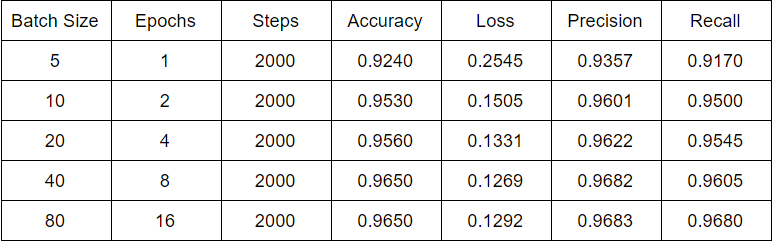



Accuracy for LENET - 5 architecture with Dropout rate of 0.4 for varying Batch Sizes

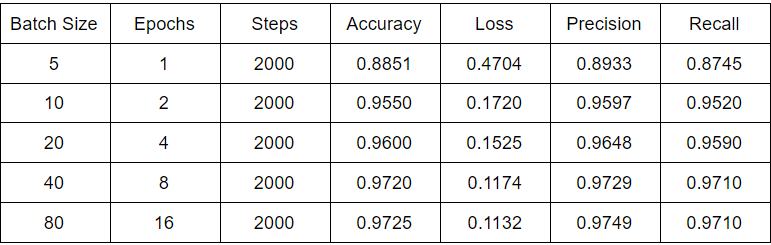


No handles with labels found to put in legend.


Text(0.5, 0, 'Batch Size')

Text(0, 0.5, 'Accuracy')

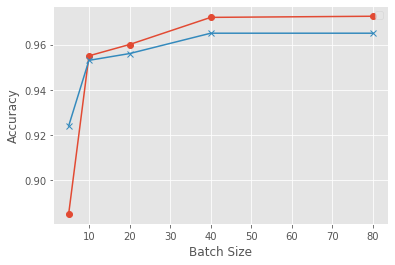

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig = plt.figure()
ax = fig.add_subplot()

x = [5, 10, 20, 40, 80]
z = [0.8851, 0.9550, 0.9600, 0.9720, 0.9725]

ax.legend()
ax.set_xlabel('Batch Size')
ax.set_ylabel('Accuracy')

ax.plot(x, z, 'o-')
ax.plot(x, z_1, 'x-')

**OBSERVATION**


When the models are trained with and without dropout for the same number of steps but with
a varying batch size and epochs adjusted according to it, even though the accuracy in case of
models with dropout is lower than the other, it is observed that the jump in the accuracy with
increase in batch size is greater in the case of models with dropout.


In [ ]:
import time

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [ ]:
time_callback = TimeHistory()
time_callback_wd = TimeHistory()

In [ ]:
lr_model = {}
lr_model_wd = {}
lr_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]


def create_lrmodel(lis):
  for i in lis:
    #create models with and without dropout  
    lr_model[i] = lenet("MNIST", i, 0.0, False, 0.0, False, 0.0, False, 0, False)
    lr_model[i].create_network()
    lr_model[i].compile_model()

    lr_model_wd[i] = lenet("MNIST", i, 0.0, True, 0.3, True, 0.3, False, 0, False)
    lr_model_wd[i].create_network()
    lr_model_wd[i].compile_model()
  
create_lrmodel(lr_list)

In [ ]:
lr_history = {}
lr_history_wd = {}

lr_time = {}
lr_time_wd = {}

for i in lr_list:
  print("################# Training model for learning rate", i , "without dropout #################")
  lr_model[i].fit_model(X_train, y_train, [time_callback], 2, 10, 0.0)
  lr_time[i] = time_callback.times
  lr_model[i].test_model(X_test, y_test)
  lr_history[i] = history
  print("################# Training model for batch size", i , "with dropout #################")
  lr_model_wd[i].fit_model(X_train, y_train, [time_callback_wd], 2, 10, 0.0)
  lr_time_wd[i] = time_callback_wd.times
  lr_model_wd[i].test_model(X_test, y_test)
  lr_history_wd[i] = history 
  print()

################# Training model for learning rate 0.01 without dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.0937 - accuracy: 0.9742 - auc_365: 0.9990 - recall_365: 0.9672 - precision_365: 0.9794
Epoch 2/2
1000/1000 - 5s - loss: 0.0844 - accuracy: 0.9753 - auc_365: 0.9992 - recall_365: 0.9709 - precision_365: 0.9810


63/63 [==============================] - 0s 6ms/step - loss: 0.1496 - accuracy: 0.9505 - auc_365: 0.9978 - recall_365: 0.9415 - precision_365: 0.9602


[0.14960460364818573,
 0.9505000114440918,
 0.9977651238441467,
 0.9415000081062317,
 0.9602243900299072]

################# Training model for batch size 0.01 with dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1678 - accuracy: 0.9485 - auc_366: 0.9971 - recall_366: 0.9411 - precision_366: 0.9565
Epoch 2/2
1000/1000 - 5s - loss: 0.1597 - accuracy: 0.9515 - auc_366: 0.9974 - recall_366: 0.9426 - precision_366: 0.9603


63/63 [==============================] - 0s 6ms/step - loss: 0.1429 - accuracy: 0.9490 - auc_366: 0.9981 - recall_366: 0.9445 - precision_366: 0.9560


[0.14294745028018951,
 0.9490000009536743,
 0.9981393218040466,
 0.9445000290870667,
 0.9559716582298279]


################# Training model for learning rate 0.02 without dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1253 - accuracy: 0.9628 - auc_367: 0.9983 - recall_367: 0.9552 - precision_367: 0.9721
Epoch 2/2
1000/1000 - 5s - loss: 0.1030 - accuracy: 0.9688 - auc_367: 0.9988 - recall_367: 0.9628 - precision_367: 0.9752


63/63 [==============================] - 0s 5ms/step - loss: 0.1624 - accuracy: 0.9485 - auc_367: 0.9973 - recall_367: 0.9385 - precision_367: 0.9601


[0.1624167263507843,
 0.9484999775886536,
 0.9972749352455139,
 0.9384999871253967,
 0.9601023197174072]

################# Training model for batch size 0.02 with dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.2398 - accuracy: 0.9275 - auc_368: 0.9948 - recall_368: 0.9166 - precision_368: 0.9427
Epoch 2/2
1000/1000 - 5s - loss: 0.2050 - accuracy: 0.9379 - auc_368: 0.9957 - recall_368: 0.9284 - precision_368: 0.9491


63/63 [==============================] - 0s 5ms/step - loss: 0.2372 - accuracy: 0.9245 - auc_368: 0.9949 - recall_368: 0.9155 - precision_368: 0.9337


[0.23716920614242554,
 0.9244999885559082,
 0.9948746562004089,
 0.9154999852180481,
 0.9337072968482971]


################# Training model for learning rate 0.03 without dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1662 - accuracy: 0.9499 - auc_369: 0.9974 - recall_369: 0.9408 - precision_369: 0.9601
Epoch 2/2
1000/1000 - 5s - loss: 0.1278 - accuracy: 0.9606 - auc_369: 0.9983 - recall_369: 0.9550 - precision_369: 0.9686


63/63 [==============================] - 0s 5ms/step - loss: 0.1870 - accuracy: 0.9380 - auc_369: 0.9967 - recall_369: 0.9320 - precision_369: 0.9486


[0.1870214343070984,
 0.9380000233650208,
 0.996666669845581,
 0.9319999814033508,
 0.9486005306243896]

################# Training model for batch size 0.03 with dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1979 - accuracy: 0.9418 - auc_370: 0.9961 - recall_370: 0.9318 - precision_370: 0.9532
Epoch 2/2
1000/1000 - 5s - loss: 0.1549 - accuracy: 0.9535 - auc_370: 0.9972 - recall_370: 0.9471 - precision_370: 0.9609


63/63 [==============================] - 0s 6ms/step - loss: 0.1177 - accuracy: 0.9580 - auc_370: 0.9980 - recall_370: 0.9545 - precision_370: 0.9651


[0.11769381910562515,
 0.9580000042915344,
 0.9980074763298035,
 0.9545000195503235,
 0.9651162624359131]


################# Training model for learning rate 0.04 without dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1362 - accuracy: 0.9595 - auc_371: 0.9978 - recall_371: 0.9523 - precision_371: 0.9668
Epoch 2/2
1000/1000 - 5s - loss: 0.0989 - accuracy: 0.9700 - auc_371: 0.9986 - recall_371: 0.9659 - precision_371: 0.9753


63/63 [==============================] - 0s 5ms/step - loss: 0.1764 - accuracy: 0.9450 - auc_371: 0.9968 - recall_371: 0.9395 - precision_371: 0.9528


[0.1763744205236435,
 0.9449999928474426,
 0.9967677593231201,
 0.9394999742507935,
 0.952839732170105]

################# Training model for batch size 0.04 with dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.2119 - accuracy: 0.9353 - auc_372: 0.9954 - recall_372: 0.9254 - precision_372: 0.9457
Epoch 2/2
1000/1000 - 5s - loss: 0.1678 - accuracy: 0.9487 - auc_372: 0.9965 - recall_372: 0.9426 - precision_372: 0.9576


63/63 [==============================] - 0s 6ms/step - loss: 0.1648 - accuracy: 0.9460 - auc_372: 0.9969 - recall_372: 0.9410 - precision_372: 0.9510


[0.1648232787847519,
 0.9459999799728394,
 0.9969335794448853,
 0.9409999847412109,
 0.9509853720664978]


################# Training model for learning rate 0.05 without dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1336 - accuracy: 0.9585 - auc_373: 0.9979 - recall_373: 0.9521 - precision_373: 0.9657
Epoch 2/2
1000/1000 - 5s - loss: 0.0991 - accuracy: 0.9676 - auc_373: 0.9987 - recall_373: 0.9628 - precision_373: 0.9732


63/63 [==============================] - 0s 5ms/step - loss: 0.1558 - accuracy: 0.9515 - auc_373: 0.9962 - recall_373: 0.9480 - precision_373: 0.9547


[0.1558188945055008,
 0.9514999985694885,
 0.9961743354797363,
 0.9480000138282776,
 0.9546827673912048]

################# Training model for batch size 0.05 with dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.2108 - accuracy: 0.9359 - auc_374: 0.9954 - recall_374: 0.9267 - precision_374: 0.9469
Epoch 2/2
1000/1000 - 5s - loss: 0.1673 - accuracy: 0.9493 - auc_374: 0.9966 - recall_374: 0.9445 - precision_374: 0.9575


63/63 [==============================] - 0s 6ms/step - loss: 0.1603 - accuracy: 0.9470 - auc_374: 0.9970 - recall_374: 0.9445 - precision_374: 0.9516


[0.16030031442642212,
 0.9470000267028809,
 0.9969851970672607,
 0.9445000290870667,
 0.9516372680664062]


################# Training model for learning rate 0.06 without dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1170 - accuracy: 0.9636 - auc_375: 0.9985 - recall_375: 0.9578 - precision_375: 0.9692
Epoch 2/2
1000/1000 - 5s - loss: 0.0838 - accuracy: 0.9744 - auc_375: 0.9992 - recall_375: 0.9706 - precision_375: 0.9790


63/63 [==============================] - 0s 6ms/step - loss: 0.1546 - accuracy: 0.9545 - auc_375: 0.9974 - recall_375: 0.9505 - precision_375: 0.9591


[0.1546439528465271,
 0.9545000195503235,
 0.9974048137664795,
 0.9505000114440918,
 0.959132194519043]

################# Training model for batch size 0.06 with dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1802 - accuracy: 0.9435 - auc_376: 0.9964 - recall_376: 0.9354 - precision_376: 0.9532
Epoch 2/2
1000/1000 - 5s - loss: 0.1508 - accuracy: 0.9536 - auc_376: 0.9970 - recall_376: 0.9488 - precision_376: 0.9606


63/63 [==============================] - 0s 6ms/step - loss: 0.1305 - accuracy: 0.9595 - auc_376: 0.9969 - recall_376: 0.9560 - precision_376: 0.9632


[0.13050003349781036,
 0.9595000147819519,
 0.9969243407249451,
 0.9559999704360962,
 0.9632241725921631]


################# Training model for learning rate 0.07 without dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1139 - accuracy: 0.9637 - auc_377: 0.9984 - recall_377: 0.9593 - precision_377: 0.9700
Epoch 2/2
1000/1000 - 5s - loss: 0.0850 - accuracy: 0.9740 - auc_377: 0.9990 - recall_377: 0.9715 - precision_377: 0.9771


63/63 [==============================] - 0s 6ms/step - loss: 0.1227 - accuracy: 0.9590 - auc_377: 0.9970 - recall_377: 0.9550 - precision_377: 0.9656


[0.12274318188428879,
 0.9589999914169312,
 0.9970207214355469,
 0.9549999833106995,
 0.965621829032898]

################# Training model for batch size 0.07 with dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1835 - accuracy: 0.9450 - auc_378: 0.9958 - recall_378: 0.9375 - precision_378: 0.9531
Epoch 2/2
1000/1000 - 5s - loss: 0.1464 - accuracy: 0.9552 - auc_378: 0.9971 - recall_378: 0.9512 - precision_378: 0.9621


63/63 [==============================] - 0s 6ms/step - loss: 0.1465 - accuracy: 0.9560 - auc_378: 0.9961 - recall_378: 0.9530 - precision_378: 0.9592


[0.14648427069187164,
 0.9559999704360962,
 0.9961493611335754,
 0.953000009059906,
 0.9592350125312805]


################# Training model for learning rate 0.08 without dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1129 - accuracy: 0.9652 - auc_379: 0.9983 - recall_379: 0.9610 - precision_379: 0.9695
Epoch 2/2
1000/1000 - 5s - loss: 0.0780 - accuracy: 0.9752 - auc_379: 0.9990 - recall_379: 0.9724 - precision_379: 0.9791


63/63 [==============================] - 0s 6ms/step - loss: 0.1175 - accuracy: 0.9610 - auc_379: 0.9981 - recall_379: 0.9565 - precision_379: 0.9657


[0.11749362200498581,
 0.9610000252723694,
 0.9980568885803223,
 0.9564999938011169,
 0.9656739234924316]

################# Training model for batch size 0.08 with dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1902 - accuracy: 0.9407 - auc_380: 0.9958 - recall_380: 0.9336 - precision_380: 0.9492
Epoch 2/2
1000/1000 - 5s - loss: 0.1561 - accuracy: 0.9509 - auc_380: 0.9969 - recall_380: 0.9461 - precision_380: 0.9581


63/63 [==============================] - 0s 5ms/step - loss: 0.1807 - accuracy: 0.9440 - auc_380: 0.9955 - recall_380: 0.9420 - precision_380: 0.9506


[0.18065884709358215,
 0.9440000057220459,
 0.9954794645309448,
 0.9419999718666077,
 0.9505549669265747]


################# Training model for learning rate 0.09 without dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1086 - accuracy: 0.9636 - auc_381: 0.9984 - recall_381: 0.9601 - precision_381: 0.9695
Epoch 2/2
1000/1000 - 5s - loss: 0.0773 - accuracy: 0.9745 - auc_381: 0.9993 - recall_381: 0.9712 - precision_381: 0.9774


63/63 [==============================] - 0s 6ms/step - loss: 0.1488 - accuracy: 0.9565 - auc_381: 0.9967 - recall_381: 0.9555 - precision_381: 0.9579


[0.14880169928073883,
 0.9564999938011169,
 0.9966619610786438,
 0.9555000066757202,
 0.9578947424888611]

################# Training model for batch size 0.09 with dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1974 - accuracy: 0.9369 - auc_382: 0.9954 - recall_382: 0.9318 - precision_382: 0.9454
Epoch 2/2
1000/1000 - 5s - loss: 0.1424 - accuracy: 0.9559 - auc_382: 0.9970 - recall_382: 0.9524 - precision_382: 0.9600


63/63 [==============================] - 0s 6ms/step - loss: 0.1390 - accuracy: 0.9610 - auc_382: 0.9963 - recall_382: 0.9585 - precision_382: 0.9638


[0.1389724761247635,
 0.9610000252723694,
 0.9962849020957947,
 0.9585000276565552,
 0.9638009071350098]


################# Training model for learning rate 0.1 without dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1071 - accuracy: 0.9680 - auc_383: 0.9983 - recall_383: 0.9640 - precision_383: 0.9721
Epoch 2/2
1000/1000 - 5s - loss: 0.0713 - accuracy: 0.9777 - auc_383: 0.9990 - recall_383: 0.9748 - precision_383: 0.9808


63/63 [==============================] - 0s 6ms/step - loss: 0.1226 - accuracy: 0.9650 - auc_383: 0.9980 - recall_383: 0.9615 - precision_383: 0.9693


[0.12260325253009796,
 0.9649999737739563,
 0.9979941844940186,
 0.9614999890327454,
 0.9692540168762207]

################# Training model for batch size 0.1 with dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1826 - accuracy: 0.9434 - auc_384: 0.9955 - recall_384: 0.9391 - precision_384: 0.9495
Epoch 2/2
1000/1000 - 5s - loss: 0.1351 - accuracy: 0.9605 - auc_384: 0.9970 - recall_384: 0.9566 - precision_384: 0.9652


63/63 [==============================] - 0s 6ms/step - loss: 0.2056 - accuracy: 0.9360 - auc_384: 0.9936 - recall_384: 0.9330 - precision_384: 0.9419


[0.20555678009986877,
 0.9359999895095825,
 0.9936407804489136,
 0.9330000281333923,
 0.9419485330581665]


################# Training model for learning rate 0.11 without dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1043 - accuracy: 0.9654 - auc_385: 0.9984 - recall_385: 0.9621 - precision_385: 0.9695
Epoch 2/2
1000/1000 - 5s - loss: 0.0690 - accuracy: 0.9780 - auc_385: 0.9992 - recall_385: 0.9759 - precision_385: 0.9807


63/63 [==============================] - 0s 6ms/step - loss: 0.1490 - accuracy: 0.9590 - auc_385: 0.9962 - recall_385: 0.9555 - precision_385: 0.9637


[0.1490067094564438,
 0.9589999914169312,
 0.9962303042411804,
 0.9555000066757202,
 0.9636913537979126]

################# Training model for batch size 0.11 with dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1937 - accuracy: 0.9415 - auc_386: 0.9953 - recall_386: 0.9363 - precision_386: 0.9484
Epoch 2/2
1000/1000 - 5s - loss: 0.1562 - accuracy: 0.9530 - auc_386: 0.9960 - recall_386: 0.9502 - precision_386: 0.9572


63/63 [==============================] - 0s 6ms/step - loss: 0.1286 - accuracy: 0.9630 - auc_386: 0.9960 - recall_386: 0.9600 - precision_386: 0.9653


[0.1285981982946396,
 0.9629999995231628,
 0.9959558844566345,
 0.9599999785423279,
 0.965309202671051]


################# Training model for learning rate 0.12 without dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1033 - accuracy: 0.9669 - auc_387: 0.9982 - recall_387: 0.9637 - precision_387: 0.9710
Epoch 2/2
1000/1000 - 5s - loss: 0.0656 - accuracy: 0.9780 - auc_387: 0.9994 - recall_387: 0.9756 - precision_387: 0.9809


63/63 [==============================] - 0s 6ms/step - loss: 0.1431 - accuracy: 0.9570 - auc_387: 0.9961 - recall_387: 0.9555 - precision_387: 0.9593


[0.14312079548835754,
 0.9570000171661377,
 0.9960721135139465,
 0.9555000066757202,
 0.9593373537063599]

################# Training model for batch size 0.12 with dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.2020 - accuracy: 0.9415 - auc_388: 0.9944 - recall_388: 0.9371 - precision_388: 0.9495
Epoch 2/2
1000/1000 - 5s - loss: 0.1574 - accuracy: 0.9519 - auc_388: 0.9962 - recall_388: 0.9485 - precision_388: 0.9564


63/63 [==============================] - 0s 6ms/step - loss: 0.1672 - accuracy: 0.9525 - auc_388: 0.9945 - recall_388: 0.9505 - precision_388: 0.9567


[0.16721037030220032,
 0.9524999856948853,
 0.9945482611656189,
 0.9505000114440918,
 0.9567186832427979]


################# Training model for learning rate 0.13 without dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1085 - accuracy: 0.9673 - auc_389: 0.9979 - recall_389: 0.9632 - precision_389: 0.9724
Epoch 2/2
1000/1000 - 5s - loss: 0.0707 - accuracy: 0.9751 - auc_389: 0.9989 - recall_389: 0.9732 - precision_389: 0.9788


63/63 [==============================] - 0s 6ms/step - loss: 0.1137 - accuracy: 0.9660 - auc_389: 0.9973 - recall_389: 0.9625 - precision_389: 0.9703


[0.11367247998714447,
 0.9660000205039978,
 0.9973341822624207,
 0.9624999761581421,
 0.9702621102333069]

################# Training model for batch size 0.13 with dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1929 - accuracy: 0.9473 - auc_390: 0.9944 - recall_390: 0.9427 - precision_390: 0.9532
Epoch 2/2
1000/1000 - 5s - loss: 0.1531 - accuracy: 0.9537 - auc_390: 0.9961 - recall_390: 0.9500 - precision_390: 0.9592


63/63 [==============================] - 0s 7ms/step - loss: 0.1765 - accuracy: 0.9555 - auc_390: 0.9939 - recall_390: 0.9530 - precision_390: 0.9578


[0.17653077840805054,
 0.9555000066757202,
 0.9938890337944031,
 0.953000009059906,
 0.9577889442443848]


################# Training model for learning rate 0.14 without dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1008 - accuracy: 0.9698 - auc_391: 0.9982 - recall_391: 0.9672 - precision_391: 0.9741
Epoch 2/2
1000/1000 - 5s - loss: 0.0670 - accuracy: 0.9776 - auc_391: 0.9994 - recall_391: 0.9756 - precision_391: 0.9793


63/63 [==============================] - 0s 6ms/step - loss: 0.1261 - accuracy: 0.9625 - auc_391: 0.9965 - recall_391: 0.9610 - precision_391: 0.9668


[0.12612205743789673,
 0.9624999761581421,
 0.9965072274208069,
 0.9610000252723694,
 0.9668008089065552]

################# Training model for batch size 0.14 with dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.2107 - accuracy: 0.9396 - auc_392: 0.9938 - recall_392: 0.9349 - precision_392: 0.9450
Epoch 2/2
1000/1000 - 5s - loss: 0.1614 - accuracy: 0.9531 - auc_392: 0.9956 - recall_392: 0.9492 - precision_392: 0.9570


63/63 [==============================] - 0s 6ms/step - loss: 0.1619 - accuracy: 0.9565 - auc_392: 0.9947 - recall_392: 0.9550 - precision_392: 0.9593


[0.16189733147621155,
 0.9564999938011169,
 0.9947147965431213,
 0.9549999833106995,
 0.9593169093132019]


################# Training model for learning rate 0.15 without dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1041 - accuracy: 0.9666 - auc_393: 0.9983 - recall_393: 0.9634 - precision_393: 0.9700
Epoch 2/2
1000/1000 - 5s - loss: 0.0700 - accuracy: 0.9785 - auc_393: 0.9990 - recall_393: 0.9763 - precision_393: 0.9819


63/63 [==============================] - 0s 6ms/step - loss: 0.1336 - accuracy: 0.9575 - auc_393: 0.9967 - recall_393: 0.9545 - precision_393: 0.9593


[0.13356845080852509,
 0.9574999809265137,
 0.9966522455215454,
 0.9545000195503235,
 0.959296464920044]

################# Training model for batch size 0.15 with dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.2038 - accuracy: 0.9415 - auc_394: 0.9942 - recall_394: 0.9364 - precision_394: 0.9467
Epoch 2/2
1000/1000 - 5s - loss: 0.1703 - accuracy: 0.9510 - auc_394: 0.9952 - recall_394: 0.9484 - precision_394: 0.9563


63/63 [==============================] - 0s 6ms/step - loss: 0.1826 - accuracy: 0.9515 - auc_394: 0.9948 - recall_394: 0.9500 - precision_394: 0.9538


[0.1826082319021225,
 0.9514999985694885,
 0.9947669506072998,
 0.949999988079071,
 0.9538152813911438]


################# Training model for learning rate 0.16 without dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1129 - accuracy: 0.9645 - auc_395: 0.9979 - recall_395: 0.9604 - precision_395: 0.9680
Epoch 2/2
1000/1000 - 5s - loss: 0.0727 - accuracy: 0.9771 - auc_395: 0.9988 - recall_395: 0.9748 - precision_395: 0.9798


63/63 [==============================] - 0s 6ms/step - loss: 0.1755 - accuracy: 0.9520 - auc_395: 0.9951 - recall_395: 0.9500 - precision_395: 0.9562


[0.17552247643470764,
 0.9520000219345093,
 0.9950755834579468,
 0.949999988079071,
 0.9562153816223145]

################# Training model for batch size 0.16 with dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.2219 - accuracy: 0.9356 - auc_396: 0.9933 - recall_396: 0.9313 - precision_396: 0.9411
Epoch 2/2
1000/1000 - 5s - loss: 0.1730 - accuracy: 0.9511 - auc_396: 0.9948 - recall_396: 0.9484 - precision_396: 0.9547


63/63 [==============================] - 0s 7ms/step - loss: 0.1593 - accuracy: 0.9570 - auc_396: 0.9956 - recall_396: 0.9550 - precision_396: 0.9603


[0.15932512283325195,
 0.9570000171661377,
 0.9955853223800659,
 0.9549999833106995,
 0.9602815508842468]


################# Training model for learning rate 0.17 without dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1068 - accuracy: 0.9667 - auc_397: 0.9980 - recall_397: 0.9637 - precision_397: 0.9703
Epoch 2/2
1000/1000 - 5s - loss: 0.0704 - accuracy: 0.9787 - auc_397: 0.9988 - recall_397: 0.9761 - precision_397: 0.9804


63/63 [==============================] - 0s 7ms/step - loss: 0.1127 - accuracy: 0.9665 - auc_397: 0.9969 - recall_397: 0.9655 - precision_397: 0.9699


[0.11272910982370377,
 0.9664999842643738,
 0.9969065189361572,
 0.965499997138977,
 0.9698643684387207]

################# Training model for batch size 0.17 with dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.2445 - accuracy: 0.9296 - auc_398: 0.9924 - recall_398: 0.9262 - precision_398: 0.9355
Epoch 2/2
1000/1000 - 5s - loss: 0.2083 - accuracy: 0.9417 - auc_398: 0.9935 - recall_398: 0.9387 - precision_398: 0.9466


63/63 [==============================] - 0s 6ms/step - loss: 0.1823 - accuracy: 0.9525 - auc_398: 0.9944 - recall_398: 0.9510 - precision_398: 0.9553


[0.18228332698345184,
 0.9524999856948853,
 0.9943637251853943,
 0.9509999752044678,
 0.9552988409996033]


################# Training model for learning rate 0.18 without dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1173 - accuracy: 0.9638 - auc_399: 0.9975 - recall_399: 0.9604 - precision_399: 0.9685
Epoch 2/2
1000/1000 - 5s - loss: 0.0816 - accuracy: 0.9743 - auc_399: 0.9986 - recall_399: 0.9730 - precision_399: 0.9771


63/63 [==============================] - 0s 6ms/step - loss: 0.1343 - accuracy: 0.9645 - auc_399: 0.9967 - recall_399: 0.9615 - precision_399: 0.9668


[0.13430741429328918,
 0.9645000100135803,
 0.99674391746521,
 0.9614999890327454,
 0.9668174982070923]

################# Training model for batch size 0.18 with dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.2611 - accuracy: 0.9296 - auc_400: 0.9907 - recall_400: 0.9245 - precision_400: 0.9355
Epoch 2/2
1000/1000 - 5s - loss: 0.1993 - accuracy: 0.9464 - auc_400: 0.9936 - recall_400: 0.9431 - precision_400: 0.9497


63/63 [==============================] - 0s 6ms/step - loss: 0.1782 - accuracy: 0.9550 - auc_400: 0.9937 - recall_400: 0.9540 - precision_400: 0.9593


[0.17819665372371674,
 0.9549999833106995,
 0.9936839938163757,
 0.9539999961853027,
 0.959276020526886]


################# Training model for learning rate 0.19 without dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1221 - accuracy: 0.9618 - auc_401: 0.9975 - recall_401: 0.9585 - precision_401: 0.9668
Epoch 2/2
1000/1000 - 5s - loss: 0.0830 - accuracy: 0.9745 - auc_401: 0.9984 - recall_401: 0.9727 - precision_401: 0.9765


63/63 [==============================] - 0s 6ms/step - loss: 0.1624 - accuracy: 0.9550 - auc_401: 0.9951 - recall_401: 0.9515 - precision_401: 0.9558


[0.16236142814159393,
 0.9549999833106995,
 0.9951328635215759,
 0.9514999985694885,
 0.9558011293411255]

################# Training model for batch size 0.19 with dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.2511 - accuracy: 0.9319 - auc_402: 0.9916 - recall_402: 0.9280 - precision_402: 0.9375
Epoch 2/2
1000/1000 - 5s - loss: 0.2301 - accuracy: 0.9397 - auc_402: 0.9923 - recall_402: 0.9374 - precision_402: 0.9443


63/63 [==============================] - 0s 6ms/step - loss: 0.2279 - accuracy: 0.9400 - auc_402: 0.9924 - recall_402: 0.9380 - precision_402: 0.9437


[0.22790037095546722,
 0.9399999976158142,
 0.992432177066803,
 0.9380000233650208,
 0.9436619877815247]


################# Training model for learning rate 0.2 without dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.1175 - accuracy: 0.9634 - auc_403: 0.9973 - recall_403: 0.9606 - precision_403: 0.9672
Epoch 2/2
1000/1000 - 5s - loss: 0.0817 - accuracy: 0.9748 - auc_403: 0.9982 - recall_403: 0.9725 - precision_403: 0.9774


63/63 [==============================] - 0s 6ms/step - loss: 0.1649 - accuracy: 0.9515 - auc_403: 0.9956 - recall_403: 0.9490 - precision_403: 0.9571


[0.16490711271762848,
 0.9514999985694885,
 0.995550274848938,
 0.9490000009536743,
 0.9571356773376465]

################# Training model for batch size 0.2 with dropout #################
Epoch 1/2
1000/1000 - 5s - loss: 0.2772 - accuracy: 0.9279 - auc_404: 0.9904 - recall_404: 0.9235 - precision_404: 0.9325
Epoch 2/2
1000/1000 - 5s - loss: 0.2439 - accuracy: 0.9386 - auc_404: 0.9919 - recall_404: 0.9362 - precision_404: 0.9429


63/63 [==============================] - 0s 6ms/step - loss: 0.1767 - accuracy: 0.9545 - auc_404: 0.9940 - recall_404: 0.9530 - precision_404: 0.9568


[0.17666952311992645,
 0.9545000195503235,
 0.9939681887626648,
 0.953000009059906,
 0.9568272829055786]

Text(0.5, 0, 'Learning rate')

Text(0, 0.5, 'Accuracy')

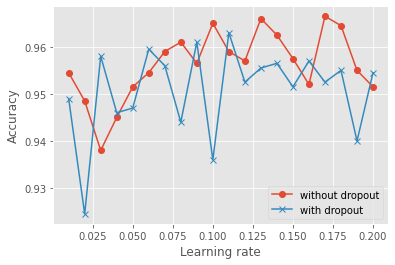

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#fig = plt.figure()
#ax = fig.add_subplot()

x = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]
y = [0.9545, 0.9485, 0.9380, 0.9450, 0.9515, 0.9545, 0.9590, 0.9610, 0.9565, 0.9650, 0.9590, 0.9570, 0.9660, 0.9625, 0.9575, 0.9520, 0.9665, 0.9645, 0.9550, 0.9515]
y_1 = [0.9490, 0.9245, 0.9580, 0.9460, 0.9470, 0.9595, 0.9560, 0.9440, 0.9610, 0.9360, 0.9630, 0.9525, 0.9555, 0.9565, 0.9515, 0.9570, 0.9525, 0.9550, 0.9400, 0.9545]

plt.xlabel('Learning rate')
plt.ylabel('Accuracy')

plt.plot(x, y, 'o-')
plt.plot(x, y_1, 'x-')
plt.legend(['without dropout', 'with dropout'], loc = 4)

Text(0.5, 0, 'Learning rate')

Text(0, 0.5, 'Loss')

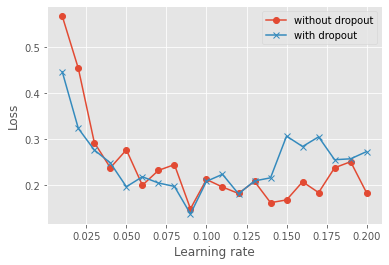

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#fig = plt.figure()
#ax = fig.add_subplot()

x = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]
y = [0.5665, 0.4536, 0.2927, 0.2382, 0.2770, 0.2004, 0.2325, 0.2450, 0.1494, 0.2128, 0.1965, 0.1825, 0.2086, 0.1626, 0.1685, 0.2078, 0.1844, 0.2382, 0.2513, 0.1836]
y_1 = [0.4459, 0.3235, 0.2766, 0.2488, 0.1971, 0.2187, 0.2052, 0.1978, 0.1382, 0.2088, 0.2240, 0.1818, 0.2097, 0.2164, 0.3068, 0.2842, 0.3052, 0.2556, 0.2576, 0.2733]


plt.xlabel('Learning rate')
plt.ylabel('Loss')

plt.plot(x, y, 'o-')
plt.plot(x, y_1, 'x-')

plt.legend(['without dropout', 'with dropout'])
plt.show()

In [ ]:
learn_time = []
learn_time_wd = []

for i in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]:
  learn_time.append(lr_time[i][0]+lr_time[i][1])
  learn_time_wd.append(lr_time_wd[i][0]+lr_time_wd[i][1])

Text(0.5, 0, 'Learning rate')

Text(0, 0.5, 'Time')

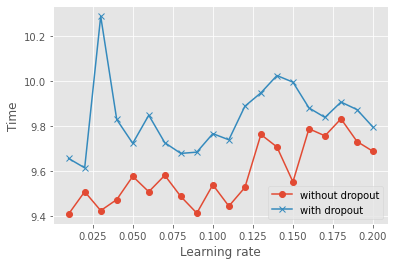

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#fig = plt.figure()
#ax = fig.add_subplot()

x = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]
y = learn_time
y_1 = learn_time_wd

plt.xlabel('Learning rate')
plt.ylabel('Time')

plt.plot(x, y, 'o-')
plt.plot(x, y_1, 'x-')
plt.legend(['without dropout', 'with dropout'], loc = 4)

## EFFECTS ON FEATURE LEARNING

LIME(Locally Interpretable Model Agnostics Explanation): Local surrogate models are interpretable models that are used to explain individual predictions of black box machine learning models. Surrogate models are trained to approximate the predictions of the underlying black box
model. Instead of training a global surrogate model, LIME focuses on training local surrogate models
to explain individual predictions.





### FOR CIFAR-10

In order to see the effects of dropout on interpretability of the models, a convolutional model
is created with four 2-D Convolutional layers followed by an Average Pooling layer and a dropout
layer, following these layers a flatten layer is added along with a final output layer of size 10. The
models are developed for a range of dropout rates from 0.0 to 0.9.


In [ ]:
pip install lime

     |████████████████████████████████| 276kB 4.0MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=5a7911b03059fd67ff744d48853b4bba36eb46dfb6a3f53b13b5b73a36b258e6
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [ ]:
y_train_cifar = y_train_cifar.reshape(50000)

In [ ]:
y_train_cifar.shape

(50000,)

In [ ]:
model = {}
for i in ([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
  model[i] = keras.Sequential(
      [
        
      layers.Conv2D(filters = 32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3), padding = "same"),
      
      layers.AvgPool2D(pool_size = (2, 2)),
      
      layers.Dropout(i),

      layers.Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding="same"),
      
      layers.AvgPool2D(pool_size = (2, 2)),
  
      layers.Dropout(i),

      layers.Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding = "same"),

      layers.AvgPool2D(pool_size = (2, 2)),

      layers.Dropout(i),

      layers.Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding = "same"),
      
      layers.AvgPool2D(pool_size = (2, 2)),

      layers.Dropout(i),

      layers.Flatten(),
      
      layers.Dense(10)
      ]
    )                 

In [ ]:
for i in ([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
  model[i].compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [ ]:
for i in ([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
  print("Training model for dropout rate", i)
  model[i].fit(
          X_train_cifar, 
          y_train_cifar, 
          epochs= 7, 
          batch_size=32, 
          validation_data = (X_test_cifar, y_test_cifar))

Training model for dropout rate 0.0
Epoch 1/7
1563/1563 [==============================] - 6s 4ms/step - loss: 0.5073 - accuracy: 0.8236 - val_loss: 0.8179 - val_accuracy: 0.7371
Epoch 2/7
1563/1563 [==============================] - 6s 4ms/step - loss: 0.4534 - accuracy: 0.8430 - val_loss: 0.9051 - val_accuracy: 0.7185
Epoch 3/7
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3997 - accuracy: 0.8608 - val_loss: 0.9217 - val_accuracy: 0.7300
Epoch 4/7
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3630 - accuracy: 0.8732 - val_loss: 0.9433 - val_accuracy: 0.7373
Epoch 5/7
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3259 - accuracy: 0.8851 - val_loss: 1.0567 - val_accuracy: 0.7363
Epoch 6/7
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3026 - accuracy: 0.8945 - val_loss: 1.1209 - val_accuracy: 0.7107
Epoch 7/7
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2777 - accuracy: 0.9023 - val

Training model for dropout rate 0.1
Epoch 1/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.9204 - accuracy: 0.3492 - val_loss: 1.2181 - val_accuracy: 0.5706
Epoch 2/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2235 - accuracy: 0.5668 - val_loss: 1.0788 - val_accuracy: 0.6213
Epoch 3/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0243 - accuracy: 0.6398 - val_loss: 0.8698 - val_accuracy: 0.6907
Epoch 4/7
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9110 - accuracy: 0.6826 - val_loss: 0.8801 - val_accuracy: 0.6964
Epoch 5/7
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8414 - accuracy: 0.7054 - val_loss: 0.8251 - val_accuracy: 0.7156
Epoch 6/7
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7730 - accuracy: 0.7311 - val_loss: 0.7936 - val_accuracy: 0.7272
Epoch 7/7
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7433 - accuracy: 0.7401 - val

Training model for dropout rate 0.2
Epoch 1/7
1563/1563 [==============================] - 6s 4ms/step - loss: 2.0103 - accuracy: 0.3181 - val_loss: 1.2970 - val_accuracy: 0.5254
Epoch 2/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3394 - accuracy: 0.5195 - val_loss: 1.1243 - val_accuracy: 0.6060
Epoch 3/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1511 - accuracy: 0.5924 - val_loss: 0.9686 - val_accuracy: 0.6666
Epoch 4/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0441 - accuracy: 0.6345 - val_loss: 0.9593 - val_accuracy: 0.6687
Epoch 5/7
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9811 - accuracy: 0.6594 - val_loss: 0.8831 - val_accuracy: 0.6935
Epoch 6/7
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9226 - accuracy: 0.6786 - val_loss: 0.8370 - val_accuracy: 0.7151
Epoch 7/7
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9004 - accuracy: 0.6831 - val

Training model for dropout rate 0.3
Epoch 1/7
1563/1563 [==============================] - 7s 4ms/step - loss: 2.1468 - accuracy: 0.2719 - val_loss: 1.4083 - val_accuracy: 0.4966
Epoch 2/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4519 - accuracy: 0.4792 - val_loss: 1.1674 - val_accuracy: 0.5907
Epoch 3/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2879 - accuracy: 0.5444 - val_loss: 1.0492 - val_accuracy: 0.6336
Epoch 4/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1766 - accuracy: 0.5830 - val_loss: 1.0183 - val_accuracy: 0.6471
Epoch 5/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1254 - accuracy: 0.6012 - val_loss: 0.9072 - val_accuracy: 0.6895
Epoch 6/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0642 - accuracy: 0.6275 - val_loss: 0.9653 - val_accuracy: 0.6631
Epoch 7/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0364 - accuracy: 0.6370 - val

Training model for dropout rate 0.4
Epoch 1/7
1563/1563 [==============================] - 7s 4ms/step - loss: 2.2354 - accuracy: 0.2496 - val_loss: 1.5194 - val_accuracy: 0.4587
Epoch 2/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5757 - accuracy: 0.4297 - val_loss: 1.3497 - val_accuracy: 0.5298
Epoch 3/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4269 - accuracy: 0.4861 - val_loss: 1.1866 - val_accuracy: 0.5860
Epoch 4/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3490 - accuracy: 0.5158 - val_loss: 1.1164 - val_accuracy: 0.6184
Epoch 5/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2778 - accuracy: 0.5443 - val_loss: 1.1239 - val_accuracy: 0.6052
Epoch 6/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2360 - accuracy: 0.5554 - val_loss: 1.1005 - val_accuracy: 0.6228
Epoch 7/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2075 - accuracy: 0.5693 - val

Training model for dropout rate 0.5
Epoch 1/7
1563/1563 [==============================] - 6s 4ms/step - loss: 2.4831 - accuracy: 0.2158 - val_loss: 1.6378 - val_accuracy: 0.4249
Epoch 2/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6691 - accuracy: 0.3885 - val_loss: 1.5099 - val_accuracy: 0.4816
Epoch 3/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5508 - accuracy: 0.4305 - val_loss: 1.4642 - val_accuracy: 0.4926
Epoch 4/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4704 - accuracy: 0.4636 - val_loss: 1.3121 - val_accuracy: 0.5454
Epoch 5/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4286 - accuracy: 0.4853 - val_loss: 1.4116 - val_accuracy: 0.5237
Epoch 6/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3834 - accuracy: 0.5027 - val_loss: 1.2977 - val_accuracy: 0.5552
Epoch 7/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3665 - accuracy: 0.5099 - val

Training model for dropout rate 0.6
Epoch 1/7
1563/1563 [==============================] - 6s 4ms/step - loss: 2.5560 - accuracy: 0.1780 - val_loss: 1.8312 - val_accuracy: 0.3269
Epoch 2/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.8034 - accuracy: 0.3277 - val_loss: 1.7897 - val_accuracy: 0.3506
Epoch 3/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6909 - accuracy: 0.3721 - val_loss: 1.7579 - val_accuracy: 0.3535
Epoch 4/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6273 - accuracy: 0.4014 - val_loss: 1.7945 - val_accuracy: 0.3461
Epoch 5/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5839 - accuracy: 0.4186 - val_loss: 1.7258 - val_accuracy: 0.3708
Epoch 6/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5637 - accuracy: 0.4291 - val_loss: 1.6203 - val_accuracy: 0.4099
Epoch 7/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5403 - accuracy: 0.4388 - val

Training model for dropout rate 0.7
Epoch 1/7
1563/1563 [==============================] - 7s 4ms/step - loss: 2.8985 - accuracy: 0.1334 - val_loss: 2.0676 - val_accuracy: 0.2380
Epoch 2/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.9422 - accuracy: 0.2665 - val_loss: 2.3321 - val_accuracy: 0.1543
Epoch 3/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.8216 - accuracy: 0.3185 - val_loss: 2.1432 - val_accuracy: 0.1789
Epoch 4/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.7650 - accuracy: 0.3426 - val_loss: 2.0665 - val_accuracy: 0.2054
Epoch 5/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.7413 - accuracy: 0.3491 - val_loss: 2.2500 - val_accuracy: 0.1649
Epoch 6/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.7271 - accuracy: 0.3584 - val_loss: 2.2190 - val_accuracy: 0.1933
Epoch 7/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.7249 - accuracy: 0.3619 - val

Training model for dropout rate 0.8
Epoch 1/7
1563/1563 [==============================] - 6s 4ms/step - loss: 5.8996 - accuracy: 0.0994 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 2/7
1563/1563 [==============================] - 6s 4ms/step - loss: 2.2686 - accuracy: 0.1402 - val_loss: 2.3314 - val_accuracy: 0.0996
Epoch 3/7
1563/1563 [==============================] - 6s 4ms/step - loss: 2.1487 - accuracy: 0.1956 - val_loss: 2.4272 - val_accuracy: 0.1000
Epoch 4/7
1563/1563 [==============================] - 6s 4ms/step - loss: 2.0746 - accuracy: 0.2133 - val_loss: 2.5927 - val_accuracy: 0.1015
Epoch 5/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.9989 - accuracy: 0.2375 - val_loss: 2.4899 - val_accuracy: 0.1165
Epoch 6/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.9602 - accuracy: 0.2547 - val_loss: 2.2700 - val_accuracy: 0.1383
Epoch 7/7
1563/1563 [==============================] - 6s 4ms/step - loss: 1.9505 - accuracy: 0.2603 - val

Training model for dropout rate 0.9
Epoch 1/7
1563/1563 [==============================] - 6s 4ms/step - loss: 16.9123 - accuracy: 0.1041 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 2/7
1563/1563 [==============================] - 6s 4ms/step - loss: 2.3036 - accuracy: 0.1098 - val_loss: 2.3027 - val_accuracy: 0.0999
Epoch 3/7
1563/1563 [==============================] - 6s 4ms/step - loss: 2.2981 - accuracy: 0.1199 - val_loss: 2.3041 - val_accuracy: 0.1000
Epoch 4/7
1563/1563 [==============================] - 6s 4ms/step - loss: 2.2734 - accuracy: 0.1466 - val_loss: 2.3201 - val_accuracy: 0.1000
Epoch 5/7
1563/1563 [==============================] - 6s 4ms/step - loss: 2.2205 - accuracy: 0.1590 - val_loss: 2.3535 - val_accuracy: 0.1000
Epoch 6/7
1563/1563 [==============================] - 6s 4ms/step - loss: 2.1969 - accuracy: 0.1643 - val_loss: 2.3826 - val_accuracy: 0.1000
Epoch 7/7
1563/1563 [==============================] - 6s 4ms/step - loss: 2.1870 - accuracy: 0.1662 - va

In [ ]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

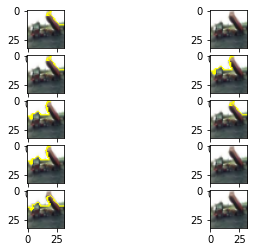

In [ ]:
plt.ion()
dropout = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range(10):
  explainer = lime_image.LimeImageExplainer(random_state=42)
  explanation = explainer.explain_instance(
        X_train_cifar[2], 
        model[dropout[i]].predict
   )
  plt.subplot(5, 2, i+1)
  plt.imshow(X_train_cifar[2])
  image, mask = explanation.get_image_and_mask(
          model[dropout[i]].predict(
          X_train_cifar[2].reshape((1,32,32,3))
          ).argmax(axis=1)[0],
          positive_only= True, 
          hide_rest=False)

  plt.imshow(mark_boundaries(image, mask))

In the below given grid of images explanability for dropout rates : [0.0, 0.3, 0.6, 0.9] respectively it was observed that as the dropout rate increased the interpretability (or explanability) of the model increased as evident from the pixels highlighted as yellow showing the most important parts of the image to predict a class by the model.




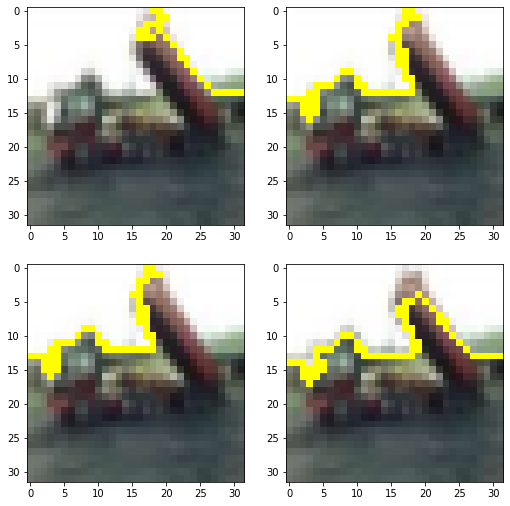

### FOR MNIST 

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((-1,28,28,1)).astype('float32') / 255.0
x_test = x_test.reshape((-1,28,28,1)).astype('float32') / 255.0

In [ ]:
import numpy as np
def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 28, 28, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb
x_train = to_rgb(x_train)
x_test = to_rgb(x_test)

In [ ]:
x_train.shape

(60000, 28, 28, 3)

In [ ]:
model = {}
for i in ([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
  model[i] = keras.Sequential(
      [
       keras.Input(shape=(28,28,3)),
       layers.Conv2D(16, 3, activation='relu'),
       layers.MaxPooling2D(),
       layers.Flatten(),
       layers.Dense(10)
      ]
  )


In [ ]:
for i in ([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
  model[i].compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [ ]:
for i in ([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
  print("Training model for", i,".......")
  model[i].fit(
          x_train, 
          y_train, 
          epochs=2, 
          batch_size=32, 
          validation_data = (x_test, y_test))

Training model for 0.0 .......
Epoch 1/2
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0651 - accuracy: 0.9805 - val_loss: 0.0574 - val_accuracy: 0.9812
Epoch 2/2
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0527 - accuracy: 0.9840 - val_loss: 0.0592 - val_accuracy: 0.9809
Training model for 0.1 .......
Epoch 1/2
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0624 - accuracy: 0.9815 - val_loss: 0.0775 - val_accuracy: 0.9754
Epoch 2/2
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0534 - accuracy: 0.9839 - val_loss: 0.0642 - val_accuracy: 0.9784
Training model for 0.2 .......
Epoch 1/2
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0669 - accuracy: 0.9801 - val_loss: 0.0659 - val_accuracy: 0.9774
Epoch 2/2
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0549 - accuracy: 0.9829 - val_loss: 0.0598 - val_accuracy: 0.9807
Training model for 0.3 .......
Epoch 1/2
1875/187

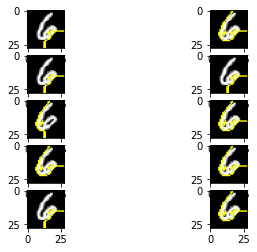

In [ ]:
plt.ion()
dropout = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range(10):
  explainer = lime_image.LimeImageExplainer(random_state=42)
  explanation = explainer.explain_instance(
        x_train[13], 
        model[dropout[i]].predict
   )
  plt.subplot(5, 2, i+1)
  plt.imshow(x_train[13])
  image, mask = explanation.get_image_and_mask(
          model[dropout[i]].predict(
          x_train[13].reshape((1,28,28,3))
          ).argmax(axis=1)[0],
          positive_only= True, 
          hide_rest=False)

  plt.imshow(mark_boundaries(image, mask))

In the below given grid of images explanability for dropout rates : [0.0, 0.3, 0.6, 0.9] respectively it was observed that as the dropout rate increased the interpretability (or explanability) of the model increased as evident from the pixels highlighted as yellow showing the most important parts of the image to predict a class by the model.



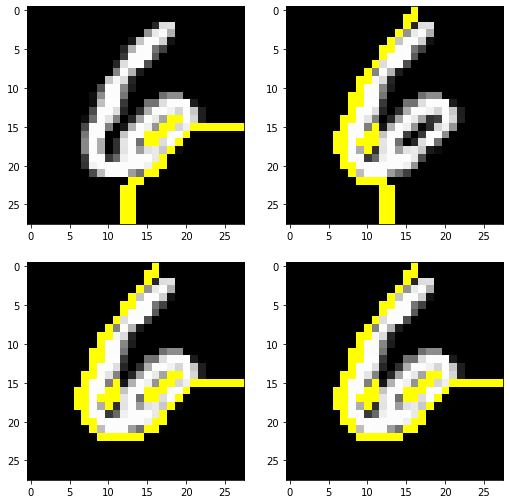

It has been evident from the training of the models that as the dropout increases the accuracy of
the model decreases therefore, under the following assumptions we could extend the relationship of
accuracy and interpretability to dropout rates:


Assumption 1: The model should not be too complex as compared to the dataset such a model
will not give a continuously increasing accuracy with the increase in dropout rate.


Assumption 2: The model is not underfitting the data as applying dropouts to such a model would
make the model parameters worse with the increasing dropout rate.


If in a given condition the above assumptions are true the accuracy of the model will mostly
increase from till a threshold and then decrease beyond that. Therefore as evident from the above
images the overall interpretability of the model is increasing with a decrease in accuracy and increase
in dropout rate.


Mathematical Representation:


𝐴𝑐𝑐𝑢𝑟𝑎𝑐𝑦 α 1/ 𝐼𝑛𝑡𝑒𝑟𝑝𝑟𝑒𝑡𝑎𝑏𝑖𝑙𝑖𝑡𝑦


Let, 𝐼𝑛𝑡𝑒𝑟𝑝𝑟𝑒𝑡𝑎𝑏𝑖𝑙𝑖𝑡y*_*𝑡ℎ imply Interpretability at an optimum threshold of dropout.


Therefore, 𝐴𝑐𝑐𝑢𝑟𝑎𝑐𝑦 α 𝐷𝑟𝑜𝑝𝑜𝑢𝑡 𝑟𝑎𝑡𝑒 (till the optimum threshold of dropout) 


𝐷𝑟𝑜𝑝𝑜𝑢𝑡 𝑟𝑎𝑡𝑒 α 1/ 𝐼𝑛𝑡𝑒𝑟𝑝𝑟𝑒𝑡𝑎𝑏𝑖𝑙𝑖𝑡𝑦


Once the dropout rate goes beyond the threshold:


𝐷𝑟𝑜𝑝𝑜𝑢𝑡 𝑟𝑎𝑡𝑒 α 1/𝐴𝑐𝑐𝑢𝑟𝑎𝑐𝑦


and, 𝐷𝑟𝑜𝑝𝑜𝑢𝑡 𝑟𝑎𝑡𝑒 α 𝐼𝑛𝑡𝑒𝑟𝑝𝑟𝑒𝑡𝑎𝑏𝑖𝑙𝑖𝑡𝑦

## Text Classification

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train_imdb = np.load(r'/gdrive/My Drive/X_train_imdb.npy')

In [ ]:
X_test_imdb = np.load(r'/gdrive/My Drive/X_test_imdb.npy')

In [ ]:
y_train_imdb = np.load(r'/gdrive/My Drive/y_train_imdb.npy', allow_pickle=True)
y_train_imdb = np.asarray(y_train_imdb).astype(np.float32)

In [ ]:
y_test_imdb = np.load(r'/gdrive/My Drive/y_test_imdb.npy', allow_pickle=True)
y_test_imdb = np.asarray(y_test_imdb).astype(np.float32)

In [ ]:
def create_network(lr, momentum, layer_size, dropout_prob, maxnorm_num, decay_lr):
#The following function is used to create a network according to the dropout sizes passed as a list to the function   
  model = Sequential()
  model.add(Embedding(5000, 32, input_length=500))
  model.add(Flatten())
  #Loop iterates over layer sizes to add dense layers to model
  for i in layer_size:
    try: #Checks if maxnorm parameter is given or not and adds a layer accordingly
      num = maxnorm_num.pop(0)
      model.add(Dense(i, activation='relu', bias_constraint=max_norm(num)))
    except: #else creates a dense layer without maxnorm constraint 
      model.add(Dense(i, activation='relu'))
    try:# Similarly checks for dropout_prob
      prob = dropout_prob.pop(0)
      model.add(Dropout(prob))
    except:
      pass
  
  # Add a final output layer with softmax activation
  model.add(Dense(1, activation = 'sigmoid'))

  return model

In [ ]:
#Creating models based on the dropout rates from 0.0 to 0.9
dropout_lis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ann_models = {}
for i in dropout_lis:
  ann_models[i] = create_network(0.1, 0.0, [10, 10], [i, i], [], False)
  ann_models[i].compile(optimizer = 'Adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [ ]:
#Train models on the IMDB Review dataset for all the dropout rates from 0.0 to 0.9 
model_history = {}
for i in dropout_lis:
  print("Training model for dropout rate",i,".......")
  model_history[i] = ann_models[i].fit(X_train_imdb, y_train_imdb, epochs = 7, batch_size = 100, validation_split= 0.1, verbose=2)

Training model for dropout rate 0.0 .......
Epoch 1/7
225/225 - 2s - loss: 1.8573e-04 - accuracy: 1.0000 - auc_30: 1.0000 - recall_30: 1.0000 - precision_30: 0.9999 - val_loss: 0.6176 - val_accuracy: 0.8760 - val_auc_30: 0.9324 - val_recall_30: 0.8728 - val_precision_30: 0.8728
Epoch 2/7
225/225 - 2s - loss: 1.5973e-04 - accuracy: 1.0000 - auc_30: 1.0000 - recall_30: 1.0000 - precision_30: 0.9999 - val_loss: 0.6276 - val_accuracy: 0.8760 - val_auc_30: 0.9313 - val_recall_30: 0.8745 - val_precision_30: 0.8716
Epoch 3/7
225/225 - 2s - loss: 1.3951e-04 - accuracy: 1.0000 - auc_30: 1.0000 - recall_30: 1.0000 - precision_30: 0.9999 - val_loss: 0.6381 - val_accuracy: 0.8768 - val_auc_30: 0.9310 - val_recall_30: 0.8728 - val_precision_30: 0.8743
Epoch 4/7
225/225 - 2s - loss: 1.2259e-04 - accuracy: 1.0000 - auc_30: 1.0000 - recall_30: 1.0000 - precision_30: 0.9999 - val_loss: 0.6476 - val_accuracy: 0.8764 - val_auc_30: 0.9305 - val_recall_30: 0.8737 - val_precision_30: 0.8730
Epoch 5/7
225/22

In [ ]:
def test_model(model, X_test, y_test):
  #Function to evaluate model on the passed dataset and return the history of the model
  history = model.evaluate(X_test, y_test)
  return history

In [ ]:
#Evaluate model by invoking test_model function 
model_test_history = {}
for i in dropout_lis:
  model_test_history[i] = test_model(ann_models[i], X_test_imdb, y_test_imdb)

782/782 [==============================] - 5s 6ms/step - loss: 0.3462 - accuracy: 0.8778 - auc_39: 0.9487 - recall_39: 0.8953 - precision_39: 0.8650


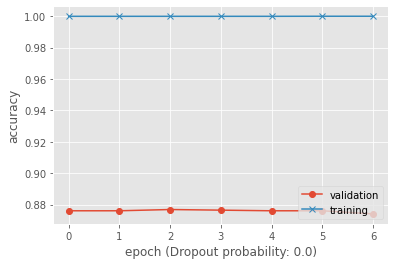

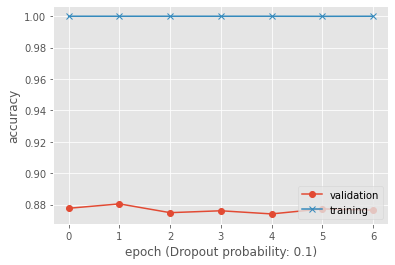

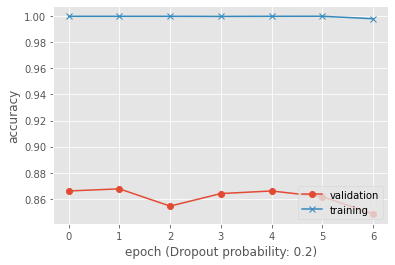

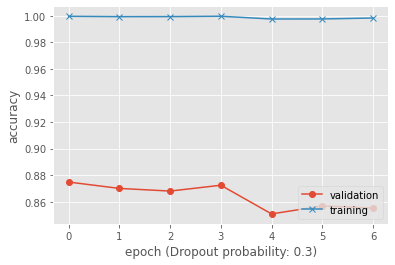

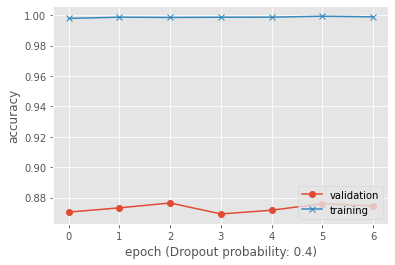

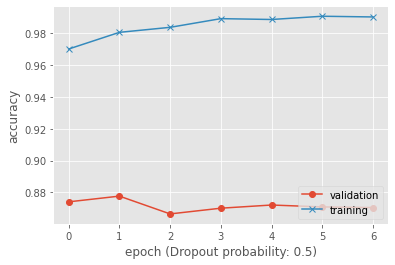

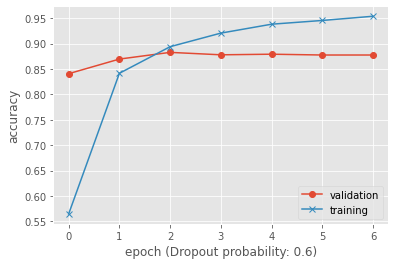

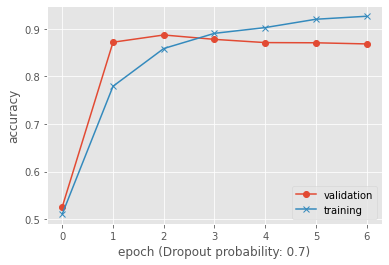

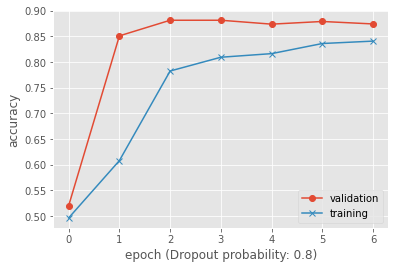

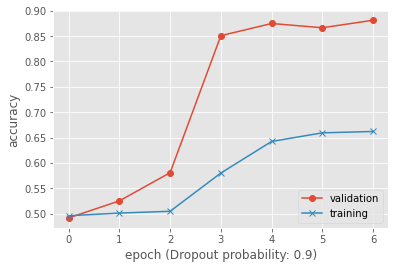

In [ ]:
#Plotting gif of learning curve for accuracy 
plot_gif(model_history, 'acc')

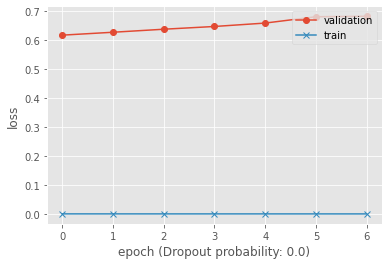

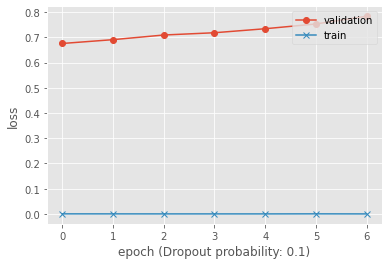

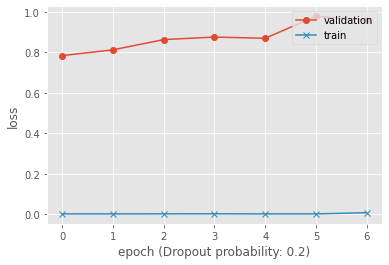

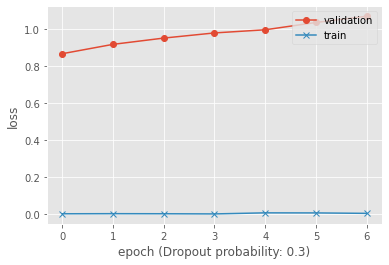

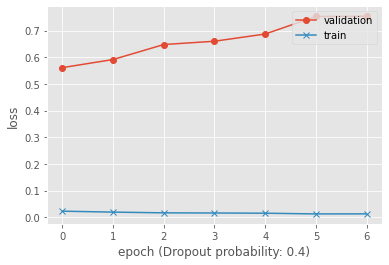

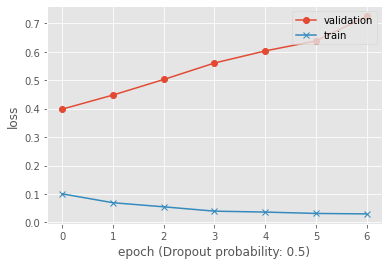

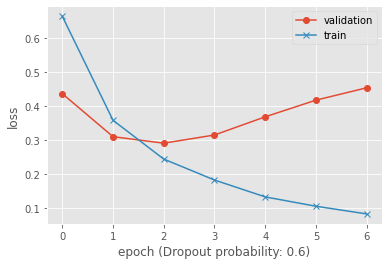

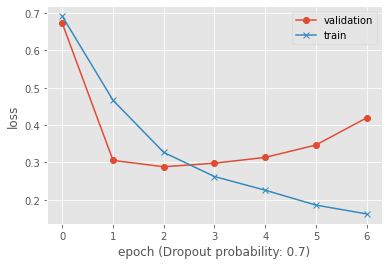

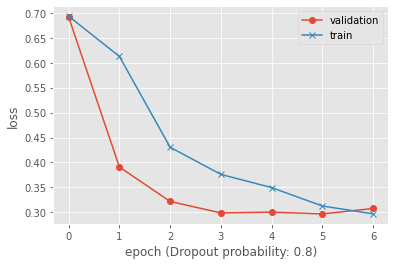

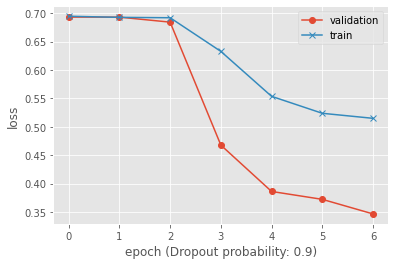

In [ ]:
#Plotting gif of learning curve for loss 
plot_gif(model_history, 'loss')

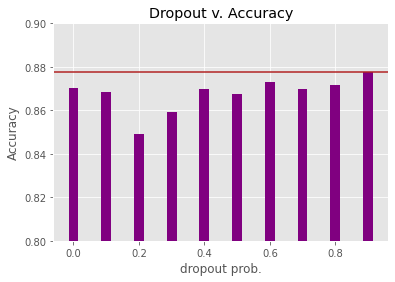

In [ ]:
#Plot bar graph to compare accuracies of the model for dropout rates from 0.0 to 0.9
acc_graph(model_test_history)

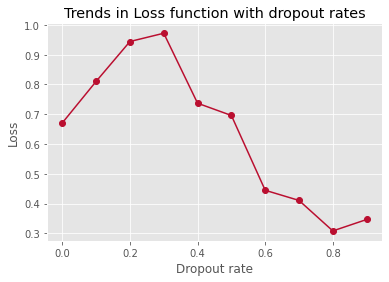

In [ ]:
#Plot line graph to compare loss of the model for dropout rates from 0.0 to 0.9
loss_graph(model_test_history)

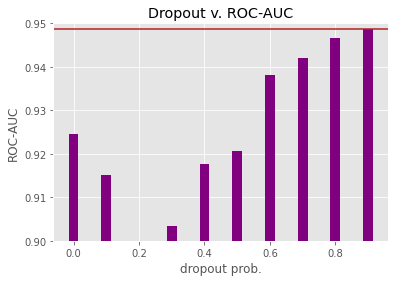

In [ ]:
#Plot bar graph to compare ROC-AUC of the model for dropout rates from 0.0 to 0.9
roc_graph(model_test_history)

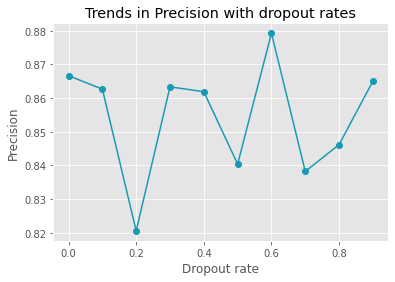

In [ ]:
#Plot line graph to compare precision of the model for dropout rates from 0.0 to 0.9
prec_graph(model_test_history)

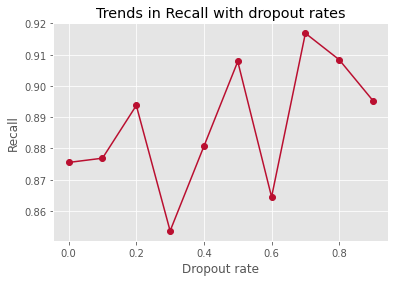

In [ ]:
#Plot line graph to compare recall of the model for dropout rates from 0.0 to 0.9

recall_graph(model_test_history)

### Effects of Batch size on accuracy with and without dropout

In [ ]:
#Dividing the dataset and getting 12,000 random samples from the datset
X_train, X_test, y_train, y_test = train_test_split(X_train_imdb, y_train_imdb, test_size=0.08, random_state=42, stratify = y_train_imdb) 

In [ ]:
bs_text_model = create_network(0.1, 0.0, [100, 100], [0.0, 0.0], [], False)
bs_text_model.compile(optimizer = 'Adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

bs_text_model_wd = create_network(0.1, 0.0, [100, 100], [0.8, 0.8], [], False)
bs_text_model_wd.compile(optimizer = 'Adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [ ]:
#Training the model with and without dropout for varying batch sizes
bs_text_history = {}
bs_text_history_wd = {}

for i, j in zip(epoch_lis, bs_lis):
  print("################# Training model for batch size",j , "without dropout #################")
  bs_text_model.fit(X_train, y_train, epochs = i, batch_size = j, validation_split= 0.0, verbose=2)
  history = test_model(bs_text_model, X_test, y_test)
  bs_text_history[i] = history
  print("################# Training model for batch size",j , "with dropout #################")
  history = bs_text_model_wd.fit(X_train, y_train, epochs = i, batch_size = j, validation_split = 0.0, verbose = 2)
  history = test_model(bs_text_model_wd, X_test, y_test)
  bs_text_history_wd[i] = history 
  print()

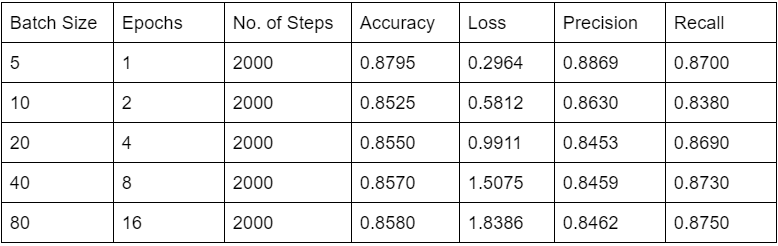



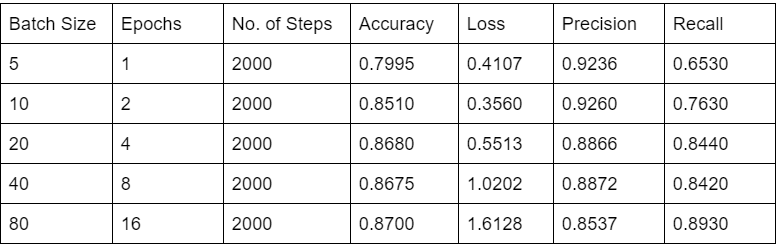

In [ ]:
lr_text_model = {}
lr_text_model_wd = {}
lr_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]

for i in lr_list:
  lr_text_model[i] = create_network(i, 0.0, [100, 100], [0.0, 0.0], [], False)
  lr_text_model[i].compile(optimizer = 'Adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])


  lr_text_model_wd[i] = create_network(i, 0.0, [100, 100], [0.8, 0.8], [], False)
  lr_text_model_wd[i].compile(optimizer = 'Adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [ ]:
#Training the model with and without dropout for varying batch sizes
lr_text_history = {}
lr_text_history_wd = {}
lr_time = {}
lr_time_wd = {}

for i in lr_list:
  print("################# Training model for learning rate",i , "without dropout #################")

  lr_text_model[i].fit(X_train, y_train, callbacks = [time_callback], epochs = 2, batch_size = 10, validation_split= 0.0, verbose=2)
  lr_time[i] = time_callback.times
  history = test_model(lr_text_model[i], X_test, y_test)
  lr_text_history[i] = history
  print("################# Training model for learning rate",i , "with dropout #################")
  history = lr_text_model_wd[i].fit(X_train, y_train, callbacks = [time_callback_wd], epochs = 2, batch_size = 10, validation_split = 0.0, verbose = 2)
  lr_time_wd[i] = time_callback_wd.times
  history = test_model(lr_text_model_wd[i], X_test, y_test)
  lr_text_history_wd[i] = history 
  print()

################# Training model for learning rate 0.01 without dropout #################
Epoch 1/2
2300/2300 - 15s - loss: 0.3875 - accuracy: 0.8154 - auc_42: 0.9058 - recall_42: 0.8021 - precision_42: 0.8240
Epoch 2/2
2300/2300 - 11s - loss: 0.1320 - accuracy: 0.9514 - auc_42: 0.9886 - recall_42: 0.9502 - precision_42: 0.9526


63/63 [==============================] - 1s 4ms/step - loss: 0.4166 - accuracy: 0.8540 - auc_42: 0.9285 - recall_42: 0.8610 - precision_42: 0.8491
################# Training model for learning rate 0.01 with dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.6075 - accuracy: 0.6361 - auc_43: 0.7123 - recall_43: 0.6428 - precision_43: 0.6343
Epoch 2/2
2300/2300 - 11s - loss: 0.3444 - accuracy: 0.8650 - auc_43: 0.9317 - recall_43: 0.8735 - precision_43: 0.8589
63/63 [==============================] - 1s 4ms/step - loss: 0.3091 - accuracy: 0.8620 - auc_43: 0.9476 - recall_43: 0.9230 - precision_43: 0.8226

################# Training model for learning rate 0.02 without dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.3944 - accuracy: 0.8062 - auc_44: 0.9007 - recall_44: 0.7910 - precision_44: 0.8159
Epoch 2/2
2300/2300 - 11s - loss: 0.1229 - accuracy: 0.9562 - auc_44: 0.9898 - recall_44: 0.9537 - precision_44: 0.9586


63/63 [==============================] - 1s 4ms/step - loss: 0.3831 - accuracy: 0.8525 - auc_44: 0.9291 - recall_44: 0.8570 - precision_44: 0.8494
################# Training model for learning rate 0.02 with dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.5920 - accuracy: 0.6512 - auc_45: 0.7339 - recall_45: 0.6417 - precision_45: 0.6541
Epoch 2/2
2300/2300 - 11s - loss: 0.3438 - accuracy: 0.8632 - auc_45: 0.9316 - recall_45: 0.8555 - precision_45: 0.8689
63/63 [==============================] - 1s 4ms/step - loss: 0.2957 - accuracy: 0.8645 - auc_45: 0.9479 - recall_45: 0.9030 - precision_45: 0.8384

################# Training model for learning rate 0.03 without dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.3904 - accuracy: 0.8126 - auc_46: 0.9035 - recall_46: 0.8097 - precision_46: 0.8143
Epoch 2/2
2300/2300 - 11s - loss: 0.1311 - accuracy: 0.9527 - auc_46: 0.9889 - recall_46: 0.9494 - precision_46: 0.9556


63/63 [==============================] - 1s 4ms/step - loss: 0.4240 - accuracy: 0.8535 - auc_46: 0.9257 - recall_46: 0.8380 - precision_46: 0.8648
################# Training model for learning rate 0.03 with dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.6963 - accuracy: 0.5068 - auc_47: 0.5146 - recall_47: 0.4644 - precision_47: 0.5075
Epoch 2/2
2300/2300 - 11s - loss: 0.4660 - accuracy: 0.7852 - auc_47: 0.8666 - recall_47: 0.7651 - precision_47: 0.7972
63/63 [==============================] - 1s 4ms/step - loss: 0.3082 - accuracy: 0.8810 - auc_47: 0.9493 - recall_47: 0.8990 - precision_47: 0.8678

################# Training model for learning rate 0.04 without dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.3792 - accuracy: 0.8230 - auc_48: 0.9101 - recall_48: 0.8377 - precision_48: 0.8138
Epoch 2/2
2300/2300 - 11s - loss: 0.1263 - accuracy: 0.9510 - auc_48: 0.9897 - recall_48: 0.9488 - precision_48: 0.9530


63/63 [==============================] - 1s 4ms/step - loss: 0.4629 - accuracy: 0.8375 - auc_48: 0.9223 - recall_48: 0.8760 - precision_48: 0.8134
################# Training model for learning rate 0.04 with dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.6970 - accuracy: 0.4970 - auc_49: 0.5004 - recall_49: 0.4913 - precision_49: 0.4970
Epoch 2/2
2300/2300 - 11s - loss: 0.6064 - accuracy: 0.6325 - auc_49: 0.7147 - recall_49: 0.6479 - precision_49: 0.6286
63/63 [==============================] - 1s 4ms/step - loss: 0.3238 - accuracy: 0.8595 - auc_49: 0.9380 - recall_49: 0.8210 - precision_49: 0.8895

################# Training model for learning rate 0.05 without dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.3826 - accuracy: 0.8163 - auc_50: 0.9079 - recall_50: 0.8113 - precision_50: 0.8196
Epoch 2/2
2300/2300 - 11s - loss: 0.1316 - accuracy: 0.9520 - auc_50: 0.9885 - recall_50: 0.9507 - precision_50: 0.9532


63/63 [==============================] - 1s 4ms/step - loss: 0.3546 - accuracy: 0.8690 - auc_50: 0.9375 - recall_50: 0.8960 - precision_50: 0.8501
################# Training model for learning rate 0.05 with dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.5779 - accuracy: 0.6608 - auc_51: 0.7504 - recall_51: 0.6451 - precision_51: 0.6660
Epoch 2/2
2300/2300 - 11s - loss: 0.3364 - accuracy: 0.8695 - auc_51: 0.9352 - recall_51: 0.8678 - precision_51: 0.8708
63/63 [==============================] - 1s 4ms/step - loss: 0.3315 - accuracy: 0.8565 - auc_51: 0.9484 - recall_51: 0.9430 - precision_51: 0.8039

################# Training model for learning rate 0.06 without dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.3894 - accuracy: 0.8098 - auc_52: 0.9037 - recall_52: 0.8145 - precision_52: 0.8069
Epoch 2/2
2300/2300 - 11s - loss: 0.1261 - accuracy: 0.9526 - auc_52: 0.9897 - recall_52: 0.9507 - precision_52: 0.9543


63/63 [==============================] - 1s 4ms/step - loss: 0.4345 - accuracy: 0.8480 - auc_52: 0.9289 - recall_52: 0.8550 - precision_52: 0.8432
################# Training model for learning rate 0.06 with dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.6881 - accuracy: 0.5295 - auc_53: 0.5528 - recall_53: 0.4994 - precision_53: 0.5314
Epoch 2/2
2300/2300 - 11s - loss: 0.4155 - accuracy: 0.8247 - auc_53: 0.8988 - recall_53: 0.8263 - precision_53: 0.8237
63/63 [==============================] - 1s 4ms/step - loss: 0.3005 - accuracy: 0.8635 - auc_53: 0.9448 - recall_53: 0.8700 - precision_53: 0.8588

################# Training model for learning rate 0.07 without dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.3865 - accuracy: 0.8139 - auc_54: 0.9059 - recall_54: 0.8010 - precision_54: 0.8221
Epoch 2/2
2300/2300 - 11s - loss: 0.1328 - accuracy: 0.9497 - auc_54: 0.9887 - recall_54: 0.9506 - precision_54: 0.9490


63/63 [==============================] - 1s 4ms/step - loss: 0.4197 - accuracy: 0.8550 - auc_54: 0.9283 - recall_54: 0.8290 - precision_54: 0.8745
################# Training model for learning rate 0.07 with dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.6563 - accuracy: 0.5668 - auc_55: 0.6170 - recall_55: 0.5528 - precision_55: 0.5687
Epoch 2/2
2300/2300 - 11s - loss: 0.3837 - accuracy: 0.8423 - auc_55: 0.9140 - recall_55: 0.8492 - precision_55: 0.8376
63/63 [==============================] - 1s 4ms/step - loss: 0.2951 - accuracy: 0.8750 - auc_55: 0.9484 - recall_55: 0.8700 - precision_55: 0.8788

################# Training model for learning rate 0.08 without dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.3822 - accuracy: 0.8205 - auc_56: 0.9086 - recall_56: 0.8130 - precision_56: 0.8254
Epoch 2/2
2300/2300 - 11s - loss: 0.1282 - accuracy: 0.9517 - auc_56: 0.9895 - recall_56: 0.9501 - precision_56: 0.9532


63/63 [==============================] - 1s 4ms/step - loss: 0.3961 - accuracy: 0.8545 - auc_56: 0.9296 - recall_56: 0.8410 - precision_56: 0.8643
################# Training model for learning rate 0.08 with dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.6900 - accuracy: 0.5260 - auc_57: 0.5391 - recall_57: 0.3925 - precision_57: 0.5355
Epoch 2/2
2300/2300 - 11s - loss: 0.4334 - accuracy: 0.8121 - auc_57: 0.8882 - recall_57: 0.7984 - precision_57: 0.8209
63/63 [==============================] - 1s 4ms/step - loss: 0.3030 - accuracy: 0.8650 - auc_57: 0.9441 - recall_57: 0.8720 - precision_57: 0.8600

################# Training model for learning rate 0.09 without dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.3800 - accuracy: 0.8178 - auc_58: 0.9089 - recall_58: 0.8159 - precision_58: 0.8190
Epoch 2/2
2300/2300 - 11s - loss: 0.1319 - accuracy: 0.9493 - auc_58: 0.9888 - recall_58: 0.9481 - precision_58: 0.9504


63/63 [==============================] - 1s 4ms/step - loss: 0.3985 - accuracy: 0.8590 - auc_58: 0.9328 - recall_58: 0.8420 - precision_58: 0.8716
################# Training model for learning rate 0.09 with dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.5717 - accuracy: 0.6699 - auc_59: 0.7613 - recall_59: 0.6603 - precision_59: 0.6732
Epoch 2/2
2300/2300 - 11s - loss: 0.3309 - accuracy: 0.8695 - auc_59: 0.9368 - recall_59: 0.8719 - precision_59: 0.8678
63/63 [==============================] - 1s 4ms/step - loss: 0.2856 - accuracy: 0.8755 - auc_59: 0.9501 - recall_59: 0.8650 - precision_59: 0.8836

################# Training model for learning rate 0.1 without dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.4027 - accuracy: 0.8005 - auc_60: 0.8960 - recall_60: 0.7751 - precision_60: 0.8165
Epoch 2/2
2300/2300 - 11s - loss: 0.1364 - accuracy: 0.9495 - auc_60: 0.9880 - recall_60: 0.9460 - precision_60: 0.9527


63/63 [==============================] - 1s 4ms/step - loss: 0.4146 - accuracy: 0.8410 - auc_60: 0.9317 - recall_60: 0.7780 - precision_60: 0.8902
################# Training model for learning rate 0.1 with dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.6154 - accuracy: 0.6243 - auc_61: 0.7007 - recall_61: 0.6292 - precision_61: 0.6231
Epoch 2/2
2300/2300 - 11s - loss: 0.3530 - accuracy: 0.8619 - auc_61: 0.9288 - recall_61: 0.8693 - precision_61: 0.8566
63/63 [==============================] - 1s 4ms/step - loss: 0.2827 - accuracy: 0.8820 - auc_61: 0.9546 - recall_61: 0.8520 - precision_61: 0.9064

################# Training model for learning rate 0.11 without dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.3884 - accuracy: 0.8143 - auc_62: 0.9051 - recall_62: 0.8097 - precision_62: 0.8172
Epoch 2/2
2300/2300 - 11s - loss: 0.1302 - accuracy: 0.9507 - auc_62: 0.9891 - recall_62: 0.9483 - precision_62: 0.9530


63/63 [==============================] - 1s 4ms/step - loss: 0.4058 - accuracy: 0.8570 - auc_62: 0.9270 - recall_62: 0.8630 - precision_62: 0.8528
################# Training model for learning rate 0.11 with dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.6661 - accuracy: 0.5623 - auc_63: 0.6031 - recall_63: 0.5539 - precision_63: 0.5633
Epoch 2/2
2300/2300 - 11s - loss: 0.4124 - accuracy: 0.8325 - auc_63: 0.9026 - recall_63: 0.8248 - precision_63: 0.8377
63/63 [==============================] - 1s 4ms/step - loss: 0.2840 - accuracy: 0.8835 - auc_63: 0.9548 - recall_63: 0.9110 - precision_63: 0.8635

################# Training model for learning rate 0.12 without dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.4050 - accuracy: 0.7956 - auc_64: 0.8941 - recall_64: 0.7981 - precision_64: 0.7941
Epoch 2/2
2300/2300 - 11s - loss: 0.1380 - accuracy: 0.9491 - auc_64: 0.9875 - recall_64: 0.9477 - precision_64: 0.9503


63/63 [==============================] - 1s 4ms/step - loss: 0.3598 - accuracy: 0.8630 - auc_64: 0.9349 - recall_64: 0.8600 - precision_64: 0.8652
################# Training model for learning rate 0.12 with dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.5984 - accuracy: 0.6437 - auc_65: 0.7237 - recall_65: 0.6335 - precision_65: 0.6468
Epoch 2/2
2300/2300 - 11s - loss: 0.3525 - accuracy: 0.8594 - auc_65: 0.9291 - recall_65: 0.8583 - precision_65: 0.8601
63/63 [==============================] - 1s 4ms/step - loss: 0.2871 - accuracy: 0.8750 - auc_65: 0.9500 - recall_65: 0.8550 - precision_65: 0.8906

################# Training model for learning rate 0.13 without dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.3968 - accuracy: 0.8037 - auc_66: 0.8992 - recall_66: 0.7958 - precision_66: 0.8086
Epoch 2/2
2300/2300 - 11s - loss: 0.1273 - accuracy: 0.9530 - auc_66: 0.9893 - recall_66: 0.9525 - precision_66: 0.9534


63/63 [==============================] - 1s 4ms/step - loss: 0.4065 - accuracy: 0.8520 - auc_66: 0.9251 - recall_66: 0.8310 - precision_66: 0.8674
################# Training model for learning rate 0.13 with dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.6682 - accuracy: 0.5627 - auc_67: 0.6013 - recall_67: 0.5292 - precision_67: 0.5672
Epoch 2/2
2300/2300 - 11s - loss: 0.3958 - accuracy: 0.8370 - auc_67: 0.9087 - recall_67: 0.8484 - precision_67: 0.8294
63/63 [==============================] - 1s 4ms/step - loss: 0.2970 - accuracy: 0.8755 - auc_67: 0.9499 - recall_67: 0.8790 - precision_67: 0.8729

################# Training model for learning rate 0.14 without dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.3805 - accuracy: 0.8210 - auc_68: 0.9094 - recall_68: 0.8146 - precision_68: 0.8252
Epoch 2/2
2300/2300 - 11s - loss: 0.1299 - accuracy: 0.9527 - auc_68: 0.9890 - recall_68: 0.9496 - precision_68: 0.9556


63/63 [==============================] - 1s 4ms/step - loss: 0.4110 - accuracy: 0.8525 - auc_68: 0.9261 - recall_68: 0.8930 - precision_68: 0.8261
################# Training model for learning rate 0.14 with dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.5942 - accuracy: 0.6490 - auc_69: 0.7297 - recall_69: 0.6566 - precision_69: 0.6468
Epoch 2/2
2300/2300 - 11s - loss: 0.3487 - accuracy: 0.8641 - auc_69: 0.9307 - recall_69: 0.8748 - precision_69: 0.8565
63/63 [==============================] - 1s 4ms/step - loss: 0.3003 - accuracy: 0.8635 - auc_69: 0.9478 - recall_69: 0.8210 - precision_69: 0.8973

################# Training model for learning rate 0.15 without dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.3898 - accuracy: 0.8135 - auc_70: 0.9041 - recall_70: 0.8083 - precision_70: 0.8168
Epoch 2/2
2300/2300 - 11s - loss: 0.1363 - accuracy: 0.9490 - auc_70: 0.9881 - recall_70: 0.9479 - precision_70: 0.9501


63/63 [==============================] - 1s 4ms/step - loss: 0.3936 - accuracy: 0.8475 - auc_70: 0.9290 - recall_70: 0.8370 - precision_70: 0.8550
################# Training model for learning rate 0.15 with dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.6262 - accuracy: 0.6180 - auc_71: 0.6879 - recall_71: 0.6421 - precision_71: 0.6126
Epoch 2/2
2300/2300 - 11s - loss: 0.3568 - accuracy: 0.8580 - auc_71: 0.9271 - recall_71: 0.8659 - precision_71: 0.8523
63/63 [==============================] - 1s 4ms/step - loss: 0.2856 - accuracy: 0.8805 - auc_71: 0.9513 - recall_71: 0.8850 - precision_71: 0.8771

################# Training model for learning rate 0.16 without dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.3809 - accuracy: 0.8194 - auc_72: 0.9090 - recall_72: 0.8239 - precision_72: 0.8166
Epoch 2/2
2300/2300 - 11s - loss: 0.1334 - accuracy: 0.9500 - auc_72: 0.9886 - recall_72: 0.9479 - precision_72: 0.9518


63/63 [==============================] - 1s 4ms/step - loss: 0.4085 - accuracy: 0.8550 - auc_72: 0.9292 - recall_72: 0.8340 - precision_72: 0.8706
################# Training model for learning rate 0.16 with dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.6453 - accuracy: 0.5885 - auc_73: 0.6474 - recall_73: 0.6782 - precision_73: 0.5750
Epoch 2/2
2300/2300 - 11s - loss: 0.3811 - accuracy: 0.8449 - auc_73: 0.9170 - recall_73: 0.8544 - precision_73: 0.8385
63/63 [==============================] - 1s 4ms/step - loss: 0.2980 - accuracy: 0.8695 - auc_73: 0.9454 - recall_73: 0.8620 - precision_73: 0.8751

################# Training model for learning rate 0.17 without dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.3805 - accuracy: 0.8200 - auc_74: 0.9087 - recall_74: 0.8065 - precision_74: 0.8289
Epoch 2/2
2300/2300 - 11s - loss: 0.1280 - accuracy: 0.9522 - auc_74: 0.9893 - recall_74: 0.9503 - precision_74: 0.9540


63/63 [==============================] - 1s 4ms/step - loss: 0.4491 - accuracy: 0.8430 - auc_74: 0.9305 - recall_74: 0.9350 - precision_74: 0.7897
################# Training model for learning rate 0.17 with dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.6983 - accuracy: 0.5007 - auc_75: 0.4998 - recall_75: 0.5237 - precision_75: 0.5007
Epoch 2/2
2300/2300 - 11s - loss: 0.5460 - accuracy: 0.7047 - auc_75: 0.7944 - recall_75: 0.6749 - precision_75: 0.7177
63/63 [==============================] - 1s 4ms/step - loss: 0.3456 - accuracy: 0.8470 - auc_75: 0.9379 - recall_75: 0.8170 - precision_75: 0.8691

################# Training model for learning rate 0.18 without dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.3878 - accuracy: 0.8107 - auc_76: 0.9045 - recall_76: 0.8320 - precision_76: 0.7979
Epoch 2/2
2300/2300 - 11s - loss: 0.1323 - accuracy: 0.9529 - auc_76: 0.9883 - recall_76: 0.9531 - precision_76: 0.9527


63/63 [==============================] - 1s 4ms/step - loss: 0.4010 - accuracy: 0.8540 - auc_76: 0.9328 - recall_76: 0.9140 - precision_76: 0.8161
################# Training model for learning rate 0.18 with dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.6508 - accuracy: 0.5836 - auc_77: 0.6400 - recall_77: 0.5832 - precision_77: 0.5836
Epoch 2/2
2300/2300 - 11s - loss: 0.3790 - accuracy: 0.8453 - auc_77: 0.9159 - recall_77: 0.8461 - precision_77: 0.8448
63/63 [==============================] - 1s 4ms/step - loss: 0.2923 - accuracy: 0.8830 - auc_77: 0.9516 - recall_77: 0.8950 - precision_77: 0.8740

################# Training model for learning rate 0.19 without dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.3885 - accuracy: 0.8140 - auc_78: 0.9049 - recall_78: 0.8156 - precision_78: 0.8129
Epoch 2/2
2300/2300 - 11s - loss: 0.1339 - accuracy: 0.9504 - auc_78: 0.9883 - recall_78: 0.9479 - precision_78: 0.9526


63/63 [==============================] - 1s 4ms/step - loss: 0.4497 - accuracy: 0.8510 - auc_78: 0.9266 - recall_78: 0.8520 - precision_78: 0.8503
################# Training model for learning rate 0.19 with dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.5644 - accuracy: 0.6803 - auc_79: 0.7714 - recall_79: 0.7059 - precision_79: 0.6716
Epoch 2/2
2300/2300 - 11s - loss: 0.3261 - accuracy: 0.8743 - auc_79: 0.9389 - recall_79: 0.8743 - precision_79: 0.8742
63/63 [==============================] - 1s 4ms/step - loss: 0.2870 - accuracy: 0.8720 - auc_79: 0.9495 - recall_79: 0.8530 - precision_79: 0.8867

################# Training model for learning rate 0.2 without dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.3939 - accuracy: 0.8093 - auc_80: 0.9015 - recall_80: 0.8021 - precision_80: 0.8138
Epoch 2/2
2300/2300 - 11s - loss: 0.1309 - accuracy: 0.9521 - auc_80: 0.9886 - recall_80: 0.9501 - precision_80: 0.9540


63/63 [==============================] - 1s 4ms/step - loss: 0.3957 - accuracy: 0.8530 - auc_80: 0.9306 - recall_80: 0.8500 - precision_80: 0.8551
################# Training model for learning rate 0.2 with dropout #################
Epoch 1/2
2300/2300 - 12s - loss: 0.6292 - accuracy: 0.6056 - auc_81: 0.6734 - recall_81: 0.5655 - precision_81: 0.6148
Epoch 2/2
2300/2300 - 11s - loss: 0.3672 - accuracy: 0.8532 - auc_81: 0.9231 - recall_81: 0.8548 - precision_81: 0.8520
63/63 [==============================] - 1s 4ms/step - loss: 0.2886 - accuracy: 0.8760 - auc_81: 0.9500 - recall_81: 0.8590 - precision_81: 0.8892



In [ ]:
for i in lr_list:
  lr_text_history_wd[i] = test_model(lr_text_model_wd[i], X_test, y_test)

63/63 [==============================] - 0s 4ms/step - loss: 0.2886 - accuracy: 0.8760 - auc_81: 0.9500 - recall_81: 0.8590 - precision_81: 0.8892


In [ ]:
for i in lr_list:
  lr_text_history[i] = test_model(lr_text_model[i], X_test, y_test)

63/63 [==============================] - 0s 4ms/step - loss: 0.3957 - accuracy: 0.8530 - auc_80: 0.9306 - recall_80: 0.8500 - precision_80: 0.8551


Text(0.5, 0, 'Learning rate')

Text(0, 0.5, 'Loss')

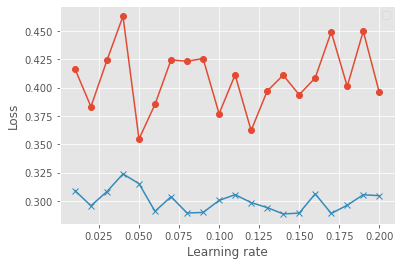

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

x = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]
y = [0.4166, 0.3831, 0.4240, 0.4629, 0.3546, 0.3852, 0.4244, 0.4232, 0.4256, 0.3769, 0.4112, 0.3621, 0.3968, 0.4110, 0.3936, 0.4085, 0.4491, 0.4010, 0.4497, 0.3957]
y_1 = [0.3091, 0.2957, 0.3082, 0.3238, 0.3152, 0.2908, 0.3037, 0.2893, 0.2898, 0.3004, 0.3055, 0.2985, 0.2941, 0.2885, 0.2892, 0.3062, 0.2889, 0.2962, 0.3054, 0.3046]

plt.legend(['w/o dropout', 'with dropout'], loc = 'best')
plt.xlabel('Learning rate')
plt.ylabel('Loss')

plt.plot(x, y, 'o-')
plt.plot(x, y_1, 'x-')

Text(0.5, 0, 'Learning rate')

Text(0, 0.5, 'Accuracy')

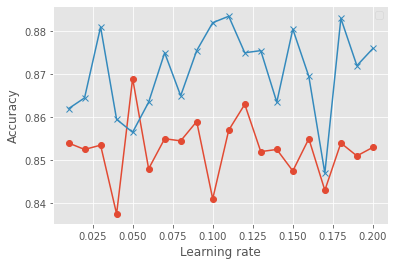

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

x = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]
y = [0.8540, 0.8525, 0.8535, 0.8375, 0.8690, 0.8480, 0.8550, 0.8545, 0.8590, 0.8410, 0.8570, 0.8630, 0.8520, 0.8525, 0.8475, 0.8550, 0.8430, 0.8540, 0.8510, 0.8530]
y_1 = [0.8620, 0.8645, 0.8810, 0.8595, 0.8565, 0.8635, 0.8750, 0.8650, 0.8755, 0.8820, 0.8835, 0.8750, 0.8755, 0.8635, 0.8805, 0.8695, 0.8470, 0.8830, 0.8720, 0.8760]

plt.legend(['w/o dropout', 'with dropout'], loc = 'best')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')

plt.plot(x, y, 'o-')
plt.plot(x, y_1, 'x-')

In [ ]:
learn_time = []
learn_time_wd = []

for i in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]:
  learn_time.append(lr_time[i][0]+lr_time[i][1])
  learn_time_wd.append(lr_time_wd[i][0]+lr_time_wd[i][1])

Text(0.5, 0, 'Learning rate')

Text(0, 0.5, 'Time')

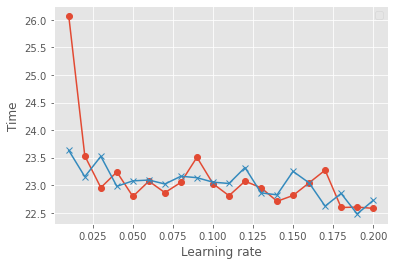

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

x = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]
y = learn_time
y_1 = learn_time_wd

plt.legend(['without dropout', 'with dropout'])
plt.xlabel('Learning rate')
plt.ylabel('Time')

plt.plot(x, y, 'o-')
plt.plot(x, y_1, 'x-')

### CONCLUSION: 


After conducting the above experiments following are the results on which we reach:


1. For Convolutional Networks:
CIFAR - 10: The most suitable dropout rate to use in this case is p = 0.3, since it gave the best
value for model parameters in comparison to the rest of the rates in the given range of 0.0 to 0.9
MNIST: The most suitable dropout rate to use in this case is p = 0.4, since it gave the best
value for a majority of model parameters including accuracy, precision, and ROC-AUC. According
to the learning curve the best fit was of the model with p = 0.6.


2. For Feed-Forward Networks:
MNIST: The most suitable dropout rate in this case is p = 0.2 as it gave the best fit according
to the learning curve and also the least loss. Other model parameters had variable optimum
dropout rates but always remained in the range of 0.1 to 0.3.


3. When the models are trained with and without dropout for the same number of steps but with
a varying batch size and epochs adjusted according to it, even though the accuracy in case of
models with dropout is lower than the other, it is observed that the jump in the accuracy with
increase in batch size is greater in the case of models with dropout.


4. In case of Text Classification it was observed that the model was very complex for the dataset
chosen and therefore without dropout the model was overfitting the dataset and gave the best
accuracy and the fit when most of the neurons were lost at very high dropout rates. In such
cases applying dropouts might not be a remedy towards over fitting as the model should be
made less complex in terms of its architecture according to the dataset.


5. On studying the effects on feature learning it was observed that given a model adheres to our
assumptions it was evident from the explanations of the surrogate models that as the dropouts
were increasing the interpretability of the model was increasing in the case of both CIFAR-10
and MNIST